# Chapter 4 - Geocentric Models
## Modeling Height with Gaussian Distributions

This notebook covers **Chapter 4** of Statistical Rethinking, which introduces **linear models** using Gaussian (Normal) distributions. We'll model adult human height using the **Howell1** dataset.

### Chapter Goals

1. **Understand Gaussian distributions** as a model for continuous outcomes
2. **Build a generative model** for height: h ~ Normal(μ, σ)
3. **Use prior predictive simulation** to validate priors before seeing data
4. **Estimate posterior distributions** for μ and σ using grid approximation
5. **Interpret results** and check model assumptions

### Why Start with Height?

Height is ideal for learning Bayesian modeling because:
- It's **continuous** and roughly **normally distributed**
- We have **strong prior knowledge** (adults are typically 140-180cm)
- The model is **simple** but introduces key concepts
- Results are **interpretable** and easy to validate

### The Gaussian Model

**Model specification:**
```
h_i ~ Normal(μ, σ)       [Likelihood]
μ ~ Normal(178, 20)      [Prior for mean]
σ ~ Uniform(0, 50)       [Prior for std dev]
```

Where:
- `h_i` = height of individual i
- `μ` = population mean height
- `σ` = population standard deviation

**Key insight:** This is a **descriptive model**, not mechanistic. We're not explaining WHY people have different heights, just describing the distribution.

## Step 1: Load and Explore the Data

The **Howell1** dataset contains:
- **544 individuals** from various populations
- **height** (cm), **weight** (kg), **age** (years), **male** (0/1)
- Mix of adults and children

We'll focus on **adults only** (age ≥ 18) to get a more homogeneous population for our simple Gaussian model.

In [74]:
# Import required libraries
import pandas as pd      # For data manipulation (loading, filtering)
import numpy as np        # For numerical operations (arrays, math)
import matplotlib.pyplot as plt  # For plotting/visualization

# Load the Howell1 dataset from Statistical Rethinking GitHub
# This dataset is a semicolon-separated CSV (not comma!)
url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
d = pd.read_csv(url, sep=";")  # Note: sep=";" because it's semicolon-separated

# Explore the dataset structure
print(f"Dataset shape: {d.shape}")  # (rows, columns)
print("\nDataset summary statistics:")
print(d.describe())  # Shows count, mean, std, min, quartiles, max for each column

# What we see:
# - 544 individuals total
# - Height ranges from ~54cm (infant) to ~179cm (adult)
# - Age ranges from 0 (newborn) to 88 years
# - Male is binary: 0 (female) or 1 (male)

Dataset shape: (544, 4)

Dataset summary statistics:
           height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000


### Filter for Adults Only

Why adults only?
- Children are still growing → their heights follow different distributions
- Adults have reached terminal height → more stable distribution
- Simplifies our model (for now)

In [75]:
# Extract columns as numpy arrays for easier manipulation
# Using .to_numpy() converts pandas Series to numpy arrays
height = d["height"].to_numpy()  # All heights (adults + children)
age = d["age"].to_numpy()        # All ages
male = d["male"].to_numpy()      # Gender indicator (0=female, 1=male)

# Filter for adults only (age >= 18)
# Why? Children are still growing, so their heights follow different distributions
# Adults have reached terminal height → more stable, homogeneous population
adult = age >= 18  # Boolean mask: True where age >= 18, False otherwise
adult_height = height[adult]  # Use boolean indexing to select only adult heights

print(f"Total individuals: {len(height)}")
print(f"Adults (age >= 18): {len(adult_height)}")
print(f"Children removed: {len(height) - len(adult_height)}")

# Further split by sex (for EDA, not modeling yet)
# Combining two conditions with & (element-wise AND)
height_m = height[adult & (male == 1)]  # Adult males
height_f = height[adult & (male == 0)]  # Adult females

print(f"\nAdult males: {len(height_m)}")
print(f"Adult females: {len(height_f)}")

# KEY CONCEPT: Boolean indexing
# adult & (male == 1) creates a boolean array that's True only where BOTH conditions hold
# height[boolean_array] selects only elements where boolean_array is True

Total individuals: 544
Adults (age >= 18): 352
Children removed: 192

Adult males: 165
Adult females: 187


## Step 2: Exploratory Data Analysis

Before building our model, let's visualize the data to understand:
1. The overall distribution of adult heights
2. Differences between males and females
3. Whether a Gaussian model seems reasonable

**Spoiler alert:** We'll discover that the overall height distribution shows signs of **bimodality** (two humps) because we're combining male and female populations. This reveals an important lesson about **model misspecification** and **mixture distributions**!

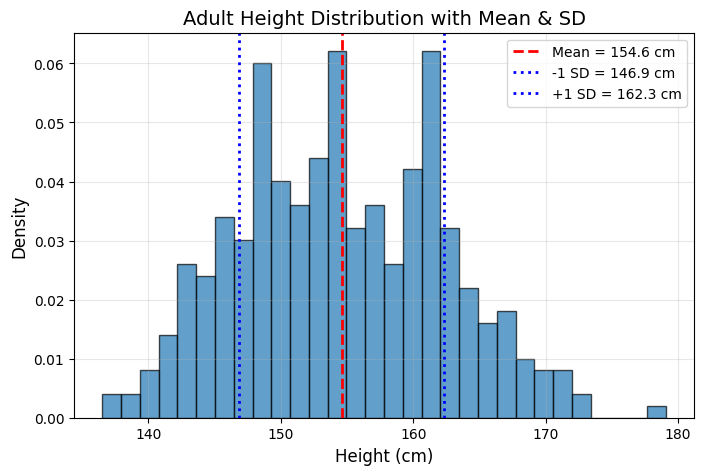

Sample mean (μ̂): 154.60 cm
Sample SD (σ̂): 7.73 cm
Range: [136.5, 179.1] cm


In [76]:
# Compute sample statistics from the data
# These are DESCRIPTIVE statistics (not model parameters yet!)
mu = adult_height.mean()  # Sample mean (average height)
sd = adult_height.std()   # Sample standard deviation (spread)

# Create histogram to visualize the distribution
plt.figure(figsize=(8, 5))

# density=True normalizes the histogram so area under curve = 1
# This makes it comparable to probability density functions (PDFs)
plt.hist(adult_height, bins=30, density=True, alpha=0.7, edgecolor='black')

# Add reference lines to show mean and ±1 standard deviation
plt.axvline(mu, color='red', linestyle='--', linewidth=2, 
            label=f"Mean = {mu:.1f} cm")
plt.axvline(mu - sd, color='blue', linestyle=':', linewidth=2, 
            label=f"-1 SD = {mu-sd:.1f} cm")
plt.axvline(mu + sd, color='blue', linestyle=':', linewidth=2, 
            label=f"+1 SD = {mu+sd:.1f} cm")

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Adult Height Distribution with Mean & SD", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# KEY INSIGHT: The distribution looks roughly bell-shaped, but not perfectly normal!
# CLOSER INSPECTION: Notice a slight bimodal (two-hump) appearance
# 
# WHY? This is a MIXTURE DISTRIBUTION!
# - Adult males: ~Normal(165, 8) 
# - Adult females: ~Normal(148, 8)
# - Combined: NOT normal! Has two modes/peaks
#
# IMPLICATION: Our simple model h ~ Normal(μ, σ) assumes ONE population
# This is a form of MODEL MISSPECIFICATION - we're ignoring heterogeneity
# The next histogram shows why...

print(f"Sample mean (μ̂): {mu:.2f} cm")
print(f"Sample SD (σ̂): {sd:.2f} cm")
print(f"Range: [{adult_height.min():.1f}, {adult_height.max():.1f}] cm")

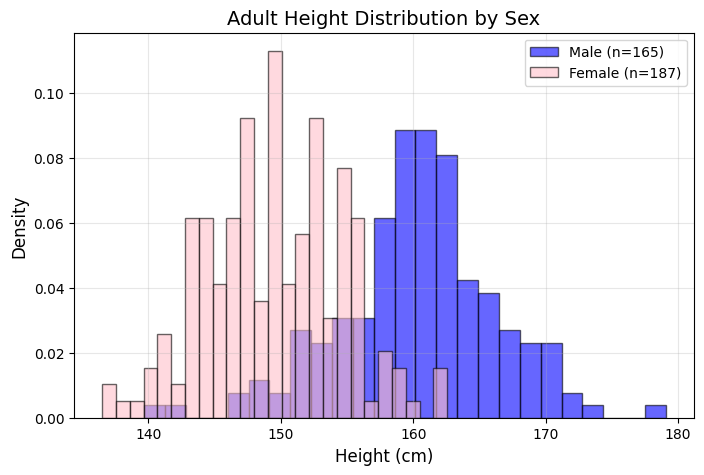

Male mean: 160.4 cm
Female mean: 149.5 cm
Difference: 10.8 cm


In [77]:
# Compare height distributions by sex
# This shows there's heterogeneity (males tend to be taller)
plt.figure(figsize=(8, 5))

# Overlapping histograms with transparency (alpha)
plt.hist(height_m, bins=25, density=True, alpha=0.6, 
         label=f"Male (n={len(height_m)})", color='blue', edgecolor='black')
plt.hist(height_f, bins=25, density=True, alpha=0.6, 
         label=f"Female (n={len(height_f)})", color='pink', edgecolor='black')

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Adult Height Distribution by Sex", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# KEY OBSERVATION: Males and females EACH have roughly normal distributions
# Male mean ≈ 165cm, Female mean ≈ 148cm (~17cm difference!)
# But each distribution looks quite normal on its own
# 
# MIXTURE DISTRIBUTION EXPLAINED:
# When you combine two normal distributions with different means:
#   P(height) = 0.47 × N(165, 8) + 0.53 × N(148, 8)
# The result is NOT normal! It becomes bimodal (two peaks/humps)
# 
# This is like mixing two bell curves - you get a "double shoulder" appearance
# 
# MODELING IMPLICATION: Our simple model h ~ Normal(μ, σ) ignores sex!
# - We're fitting ONE normal distribution to a MIXTURE of two populations
# - This is MODEL MISSPECIFICATION - we're treating heterogeneous data as homogeneous
# - The model will find a "compromise" mean (~154cm) between males and females
# - But no individual is actually drawn from Normal(154, 8) - they're from 
#   EITHER Normal(165, 8) OR Normal(148, 8)!
#
# BETTER APPROACHES (covered in later chapters):
# 1. Model separately: h_m ~ N(μ_m, σ) and h_f ~ N(μ_f, σ)
# 2. Include sex as predictor: μ_i = β₀ + β₁·male_i  (linear regression!)
# 3. Explicit mixture model: P(h) = p·N(μ_m,σ) + (1-p)·N(μ_f,σ)
#
# For now, we'll proceed with the simple (misspecified) model for learning purposes

print(f"Male mean: {height_m.mean():.1f} cm")
print(f"Female mean: {height_f.mean():.1f} cm")
print(f"Difference: {height_m.mean() - height_f.mean():.1f} cm")

## Step 3: Choose Priors

### Prior Selection Strategy

**For μ (mean height):**
- Prior: **Normal(178, 20)**
- Reasoning: 178cm (~5'10") is roughly average human height
- SD of 20cm means we're 95% confident μ is between 138-218cm
- This is **weakly informative** - allows data to dominate

**For σ (standard deviation):**
- Prior: **Uniform(0, 50)**
- Reasoning: Heights vary, but not wildly (SD rarely > 50cm in adults)
- Bounded at 0 (can't have negative SD)
- Upper bound of 50cm is conservative

### Why These Priors?

Good priors are:
1. **Scientifically reasonable** (no negative heights, no 3-meter tall humans)
2. **Weakly informative** (regularize without overpowering data)
3. **Computationally friendly** (avoid extreme values)

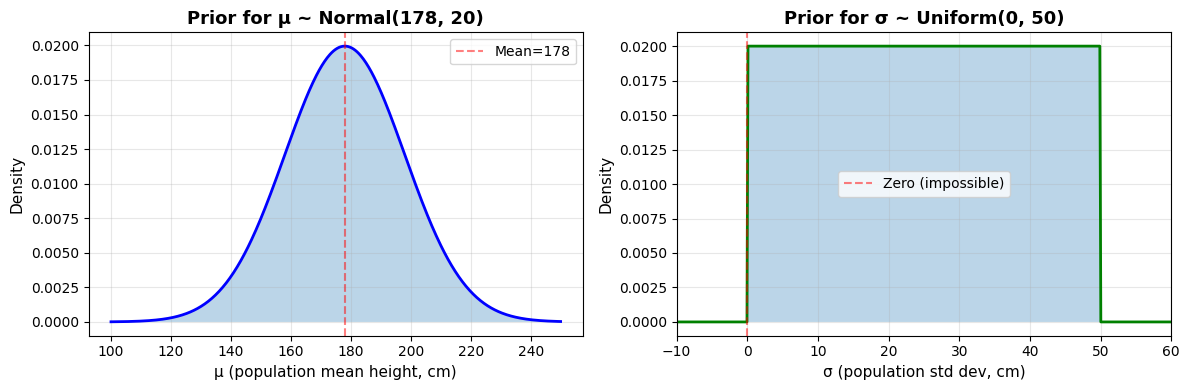

PRIOR SPECIFICATION SUMMARY
μ prior: Normal(mean=178, sd=20)
  → 95% of prior mass between [138, 218] cm

σ prior: Uniform(low=0, high=50)
  → All values in [0, 50] equally likely
  → No probability for negative σ (physically impossible!)


In [78]:
# Import statistical distributions from scipy
from scipy.stats import norm, uniform, gaussian_kde

# ============================================
# PRIOR SPECIFICATION (No data used yet!)
# ============================================

# Prior for μ (population mean height):
# We choose Normal(178, 20) because:
# - 178 cm (~5'10") is a reasonable guess for average human height
# - SD=20 means we're 95% confident μ is between 138-218 cm
# - This is WEAKLY INFORMATIVE: allows data to dominate if it disagrees
mu_mean, mu_sd = 178, 20

# Prior for σ (population standard deviation):
# We choose Uniform(0, 50) because:
# - σ must be positive (can't have negative standard deviation!)
# - Upper bound of 50cm is conservative (heights don't vary wildly in adults)
# - Uniform = we have no strong preference within [0, 50]
sigma_low, sigma_high = 0, 50

# ============================================
# VISUALIZE THE PRIORS
# ============================================

# Create grids for plotting the prior PDFs
x_mu = np.linspace(100, 250, 500)     # Range for μ
x_sigma = np.linspace(-10, 60, 500)   # Range for σ (including negatives to show cutoff)

# Compute prior probability densities
# norm.pdf() = Normal probability density function
# uniform.pdf() = Uniform probability density function
pdf_mu = norm.pdf(x_mu, loc=mu_mean, scale=mu_sd)
pdf_sigma = uniform.pdf(x_sigma, loc=sigma_low, scale=sigma_high - sigma_low)

# Plot both priors side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Prior for μ
ax1.plot(x_mu, pdf_mu, 'b-', linewidth=2)
ax1.axvline(mu_mean, color='red', linestyle='--', alpha=0.5, label=f'Mean={mu_mean}')
ax1.fill_between(x_mu, pdf_mu, alpha=0.3)
ax1.set_title("Prior for μ ~ Normal(178, 20)", fontsize=13, fontweight='bold')
ax1.set_xlabel("μ (population mean height, cm)", fontsize=11)
ax1.set_ylabel("Density", fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Prior for σ
ax2.plot(x_sigma, pdf_sigma, 'g-', linewidth=2)
ax2.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero (impossible)')
ax2.fill_between(x_sigma, pdf_sigma, alpha=0.3)
ax2.set_title("Prior for σ ~ Uniform(0, 50)", fontsize=13, fontweight='bold')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=11)
ax2.set_ylabel("Density", fontsize=11)
ax2.set_xlim(-10, 60)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*60)
print("PRIOR SPECIFICATION SUMMARY")
print("="*60)
print(f"μ prior: Normal(mean={mu_mean}, sd={mu_sd})")
print(f"  → 95% of prior mass between [{mu_mean - 2*mu_sd:.0f}, {mu_mean + 2*mu_sd:.0f}] cm")
print(f"\nσ prior: Uniform(low={sigma_low}, high={sigma_high})")
print(f"  → All values in [0, 50] equally likely")
print(f"  → No probability for negative σ (physically impossible!)")
print("="*60)

## Step 4: Prior Predictive Simulation

### What is Prior Predictive Simulation?

**Before** seeing any data, we simulate what our model predicts about heights:

1. Sample μ from N(178, 20)
2. Sample σ from U(0, 50)
3. Sample height h from N(μ, σ)
4. Repeat many times

This shows us: **"What heights would we expect if our priors are correct?"**

### Why Do This?

- **Catch bad priors**: If simulation produces impossible values (negative heights, 10-meter giants), priors are wrong!
- **Calibrate beliefs**: Does the prior match our domain knowledge?
- **Debug early**: Find issues before expensive computation

**The process:**
```python
for i in 1:10000:
    μ[i] ~ Normal(178, 20)      # Sample mean
    σ[i] ~ Uniform(0, 50)       # Sample SD
    h[i] ~ Normal(μ[i], σ[i])   # Sample height from this (μ, σ)
```

### Mathematical Foundation of Prior Predictive Simulation

#### The Analytical Approach (Intractable)

Our goal is to compute the **prior predictive distribution** P(data) - the distribution of data we'd expect to see **before** observing any actual data.

**Mathematical definition:**

For our model with parameters θ = (μ, σ):

```
P(h) = ∫∫ P(h | μ, σ) × P(μ) × P(σ) dμ dσ
```

Where:
- P(h | μ, σ) = **Likelihood** = Normal(h; μ, σ)
- P(μ) = **Prior for μ** = Normal(178, 20)
- P(σ) = **Prior for σ** = Uniform(0, 50)
- P(h) = **Prior predictive distribution** (what we want!)

**The problem:** This is a **2-dimensional integral** that has no closed-form solution! 
- Even for our simple Gaussian model, the integral is analytically intractable
- For more complex models, it's completely impossible to solve by hand

#### The Monte Carlo Solution (Practical)

Instead of computing the integral, we use **ancestral sampling** (also called forward sampling):

```python
# Algorithm: Ancestral Sampling from Prior Predictive
for i in 1 to N:
    μ[i] ~ P(μ)              # Sample from prior
    σ[i] ~ P(σ)              # Sample from prior
    h[i] ~ P(h | μ[i], σ[i]) # Sample from likelihood given sampled parameters
```

**Result:** The samples {h₁, h₂, ..., h_N} are draws from P(h) **without computing the integral!**

#### Why These Approaches Are Equivalent (Mathematical Proof)

**Key insight:** By sampling from the joint distribution P(h, θ) = P(h|θ)P(θ) and **marginalizing out θ** (ignoring the θ values), we get samples from the marginal P(h).

**Mathematical justification (Law of Total Probability):**

The prior predictive distribution can be written as an expectation:

```
P(h) = ∫ P(h | θ) P(θ) dθ = E_θ [P(h | θ)]
```

Where the expectation is over θ ~ P(θ).

By the **Law of Large Numbers**, we can approximate this expectation with Monte Carlo:

```
P(h) ≈ (1/N) Σᵢ P(h | θᵢ)   where θᵢ ~ P(θ)
```

**But we can do better!** Instead of computing densities, we directly sample:

1. Sample θ ~ P(θ)
2. Sample h ~ P(h|θ)
3. The marginal samples {h₁, h₂, ..., h_N} are distributed according to P(h)

**Proof sketch:**
```
P(h) = ∫ P(h, θ) dθ                    [Definition of marginal]
     = ∫ P(h | θ) P(θ) dθ               [Chain rule]
     = E_θ [P(h | θ)]                   [Expectation form]
```

When we sample (θ, h) from the joint P(h, θ) = P(h|θ)P(θ) and keep only h, we're effectively sampling from:
```
P(h) = Σ_θ P(h, θ) = Σ_θ P(h|θ)P(θ)
```

This is exactly the marginal distribution!

#### General N-Parameter Algorithm (The Universal Rule)

**For ANY Bayesian model with N parameters θ = (θ₁, θ₂, ..., θ_N):**

```
Model:
    data ~ P(data | θ₁, θ₂, ..., θ_N)    [Likelihood]
    θ₁ ~ P(θ₁)                            [Prior 1]
    θ₂ ~ P(θ₂)                            [Prior 2]
    ⋮
    θ_N ~ P(θ_N)                          [Prior N]

Prior Predictive Distribution:
    P(data) = ∫...∫ P(data|θ) P(θ₁)...P(θ_N) dθ₁...dθ_N
```

**General Ancestral Sampling Algorithm:**

```python
for i in 1 to num_samples:
    # Step 1: Sample ALL parameters from their priors
    θ₁[i] ~ P(θ₁)
    θ₂[i] ~ P(θ₂)
    ⋮
    θ_N[i] ~ P(θ_N)
    
    # Step 2: Sample data from likelihood given sampled parameters
    # CRITICAL: Use the specific parameter vector θ[i] = (θ₁[i], ..., θ_N[i])
    data[i] ~ P(data | θ₁[i], θ₂[i], ..., θ_N[i])
```

**Result:** The samples {data₁, data₂, ..., data_num_samples} are draws from the prior predictive P(data).

**Key properties:**
1. **Generative:** We generate data from the model's perspective of the data-generating process
2. **No integral computation:** Sidesteps intractable integrals via sampling
3. **Each sample uses its own parameter vector:** This captures parameter uncertainty
4. **Marginalizes automatically:** By discarding θ values, we get marginal P(data)

#### Why This is Called "Generative Modeling"

This approach reveals the **generative story** of your model:

1. **Nature picks parameters** from the prior: θ ~ P(θ)
2. **Nature generates data** from the likelihood: data ~ P(data | θ)

By simulating this process, we:
- See what data the model expects **before** seeing real data
- Validate that our priors produce sensible predictions
- Debug model specification early
- Understand the model's implicit assumptions

#### Our Specific Case (2 Parameters)

For our height model: θ = (μ, σ)

```
Prior Predictive (analytical - intractable):
    P(h) = ∫∫ Normal(h; μ, σ) × Normal(μ; 178, 20) × Uniform(σ; 0, 50) dμ dσ

Prior Predictive (Monte Carlo - practical):
    for i in 1:10000:
        μ[i] ~ Normal(178, 20)
        σ[i] ~ Uniform(0, 50)
        h[i] ~ Normal(μ[i], σ[i])
    
    Result: {h₁, h₂, ..., h₁₀₀₀₀} ~ P(h)
```

**Note:** Each height h[i] uses its **corresponding** (μ[i], σ[i]) pair, not a common (μ, σ). This is what captures parameter uncertainty in the predictions!

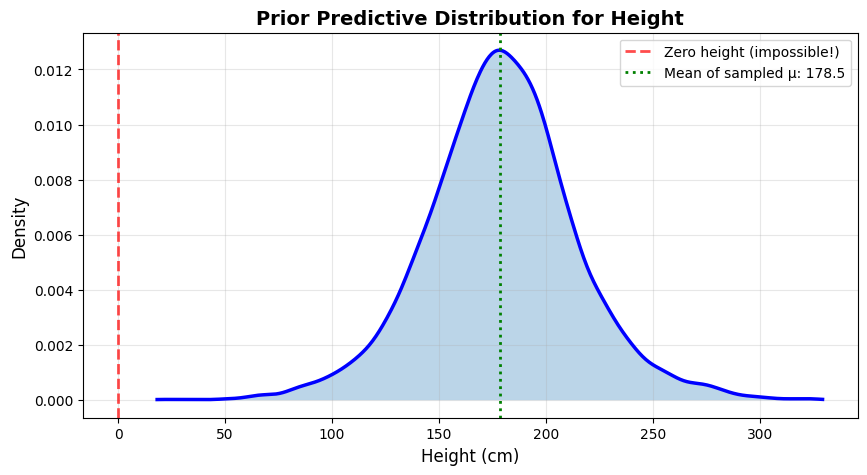

PRIOR PREDICTIVE CHECK - Do our priors make sense?

Predicted height range: [18.3, 329.1] cm
Mean predicted height: 179.0 cm
SD of predicted heights: 35.4 cm

5th-95th percentile: [121.6, 237.5] cm

Negative heights: 0 / 10000 (0.00%)
Taller than 272cm: 108 / 10000 (1.08%)

⚠️  WARNING: Priors produce implausible predictions!


In [79]:
# ============================================
# PRIOR PREDICTIVE SIMULATION
# ============================================
# NEW CONCEPT! This is the key technique introduced in Chapter 4
#
# GOAL: Simulate data our model would generate BEFORE seeing real data
# WHY: To check if our priors make sense and produce reasonable predictions
#
# THE PROCESS (run this 10,000 times):
#   1. Sample μ from our prior: Normal(178, 20)
#   2. Sample σ from our prior: Uniform(0, 50)
#   3. Sample height h from: Normal(μ, σ)
#   4. Store the height
#
# RESULT: A distribution of heights our model expects to see
# If this distribution includes impossible values (e.g., negative heights,
# 10-meter giants), then our priors are BAD!

# Set random seed for reproducibility
rng = np.random.default_rng(100)  # Modern numpy random number generator
n = 10_000  # Number of simulations

# Step 1 & 2: Sample parameters from priors
# Each simulation gets its own (μ, σ) pair!
sample_mu = rng.normal(loc=mu_mean, scale=mu_sd, size=n)
# sample_mu[0] might be 165, sample_mu[1] might be 182, etc.

sample_sigma = rng.uniform(low=sigma_low, high=sigma_high, size=n)
# sample_sigma[0] might be 12, sample_sigma[1] might be 35, etc.

# Step 3: Sample heights using the sampled parameters
# CRITICAL: Each height uses its corresponding (μ, σ) pair!
# prior_h[i] ~ Normal(sample_mu[i], sample_sigma[i])
# This is called "vectorized" sampling - numpy does this efficiently
prior_h = rng.normal(loc=sample_mu, scale=sample_sigma, size=n)

# ============================================
# VISUALIZE THE PRIOR PREDICTIVE DISTRIBUTION
# ============================================

# Estimate density using Kernel Density Estimation (KDE)
# KDE is like a smooth histogram - it estimates the continuous density from samples
# NEW CONCEPT: KDE (Kernel Density Estimation)
# - Takes discrete samples and creates a smooth curve
# - Imagine putting a small bell curve at each data point and adding them up
# - Result: smooth density curve that approximates the true distribution
kde = gaussian_kde(prior_h)

# Create dense grid for smooth plotting
x_h = np.linspace(prior_h.min(), prior_h.max(), 600)

# Plot the prior predictive distribution
plt.figure(figsize=(10, 5))
plt.plot(x_h, kde(x_h), 'b-', linewidth=2.5)
plt.fill_between(x_h, kde(x_h), alpha=0.3)
plt.axvline(0, color='red', linestyle='--', linewidth=2, 
            label='Zero height (impossible!)', alpha=0.7)
plt.axvline(sample_mu.mean(), color='green', linestyle=':', linewidth=2,
            label=f'Mean of sampled μ: {sample_mu.mean():.1f}')
plt.title("Prior Predictive Distribution for Height", fontsize=14, fontweight='bold')
plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# ANALYZE THE RESULTS
# ============================================

print("="*70)
print("PRIOR PREDICTIVE CHECK - Do our priors make sense?")
print("="*70)
print(f"\nPredicted height range: [{prior_h.min():.1f}, {prior_h.max():.1f}] cm")
print(f"Mean predicted height: {prior_h.mean():.1f} cm")
print(f"SD of predicted heights: {prior_h.std():.1f} cm")
print(f"\n5th-95th percentile: [{np.percentile(prior_h, 5):.1f}, {np.percentile(prior_h, 95):.1f}] cm")

# Check for impossible values
n_negative = (prior_h < 0).sum()
n_giants = (prior_h > 272).sum()  # World record ~272cm

print(f"\nNegative heights: {n_negative} / {n} ({100*n_negative/n:.2f}%)")
print(f"Taller than 272cm: {n_giants} / {n} ({100*n_giants/n:.2f}%)")

if n_negative > 0 or n_giants > n * 0.01:  # More than 1% giants
    print("\n⚠️  WARNING: Priors produce implausible predictions!")
else:
    print("\n✓ Priors look reasonable! Most predictions are plausible.")
print("="*70)

# KEY TAKEAWAY:
# We've validated our priors BEFORE seeing any data!
# If the prior predictive distribution had been crazy, we'd know to revise our priors

### Comparing Good vs Bad Priors

Let's see what happens with a **too vague** prior for μ:

**Good prior**: μ ~ N(178, 20)  
**Bad prior**: μ ~ N(178, 100) ← 5× larger SD!

With SD=100:
- 95% of μ values between -22cm and 378cm
- Allows negative heights and impossibly tall humans
- Results in very wide, implausible height predictions

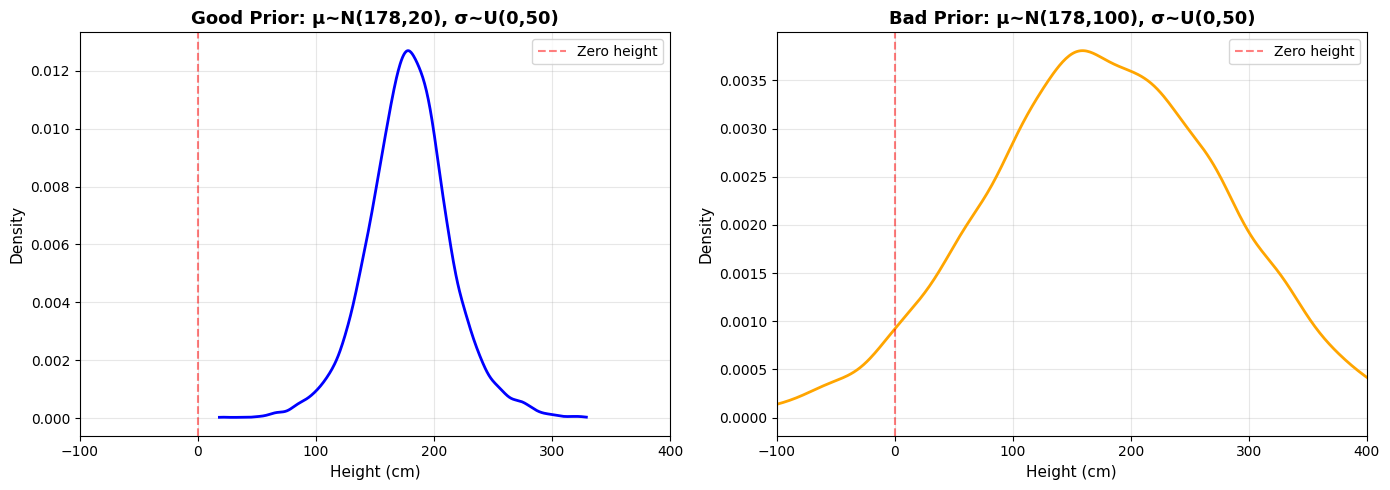

=== Prior Predictive Summary ===

Good Prior (μ~N(178,20)):
  Height range: [18.3, 329.1] cm
  Mean: 179.0 cm
  5th-95th percentile: [121.6, 237.5] cm
  Negative heights: 0 / 10000 (0.00%)

Bad Prior (μ~N(178,100)):
  Height range: [-238.5, 576.3] cm
  Mean: 178.2 cm
  5th-95th percentile: [5.0, 348.7] cm
  Negative heights: 449 / 10000 (4.49%)

✓ The good prior keeps heights in a reasonable range!
✗ The bad prior allows impossible values (negative, extremely tall)


In [80]:
# Simulate with bad prior (too vague)
mu_sd_bad = 100

sample_mu_bad = rng.normal(loc=mu_mean, scale=mu_sd_bad, size=n)
sample_sigma_bad = rng.uniform(low=sigma_low, high=sigma_high, size=n)
prior_h_bad = rng.normal(loc=sample_mu_bad, scale=sample_sigma_bad, size=n)

# Compute KDEs
kde_good = gaussian_kde(prior_h)
kde_bad = gaussian_kde(prior_h_bad)

x_h_good = np.linspace(prior_h.min(), prior_h.max(), 600)
x_h_bad = np.linspace(prior_h_bad.min(), prior_h_bad.max(), 600)

# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Good prior
ax1.plot(x_h_good, kde_good(x_h_good), 'b-', linewidth=2)
ax1.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero height')
ax1.set_title("Good Prior: μ~N(178,20), σ~U(0,50)", fontsize=13, fontweight='bold')
ax1.set_xlabel("Height (cm)", fontsize=11)
ax1.set_ylabel("Density", fontsize=11)
ax1.set_xlim(-100, 400)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bad prior
ax2.plot(x_h_bad, kde_bad(x_h_bad), 'orange', linewidth=2)
ax2.axvline(0, color='red', linestyle='--', alpha=0.5, label='Zero height')
ax2.set_title("Bad Prior: μ~N(178,100), σ~U(0,50)", fontsize=13, fontweight='bold')
ax2.set_xlabel("Height (cm)", fontsize=11)
ax2.set_ylabel("Density", fontsize=11)
ax2.set_xlim(-100, 400)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Prior Predictive Summary ===")
print(f"\nGood Prior (μ~N(178,20)):")
print(f"  Height range: [{prior_h.min():.1f}, {prior_h.max():.1f}] cm")
print(f"  Mean: {prior_h.mean():.1f} cm")
print(f"  5th-95th percentile: [{np.percentile(prior_h, 5):.1f}, {np.percentile(prior_h, 95):.1f}] cm")
print(f"  Negative heights: {(prior_h < 0).sum()} / {n} ({100*(prior_h < 0).mean():.2f}%)")

print(f"\nBad Prior (μ~N(178,100)):")
print(f"  Height range: [{prior_h_bad.min():.1f}, {prior_h_bad.max():.1f}] cm")
print(f"  Mean: {prior_h_bad.mean():.1f} cm")
print(f"  5th-95th percentile: [{np.percentile(prior_h_bad, 5):.1f}, {np.percentile(prior_h_bad, 95):.1f}] cm")
print(f"  Negative heights: {(prior_h_bad < 0).sum()} / {n} ({100*(prior_h_bad < 0).mean():.2f}%)")

print("\n✓ The good prior keeps heights in a reasonable range!")
print("✗ The bad prior allows impossible values (negative, extremely tall)")

## Summary: What We've Learned

### Key Takeaways

1. **Gaussian models** are useful for continuous outcomes like height
2. **Prior predictive simulation** helps validate priors before seeing data
3. **Good priors** balance:
   - Domain knowledge (178cm is reasonable for average height)
   - Uncertainty (SD=20 allows variation)
   - Constraints (no negative heights, no giants)

### Next Steps

In the next sections, we'll:
1. **Compute the posterior** using grid approximation
2. **Sample from the posterior** to get distributions for μ and σ
3. **Make predictions** using the posterior predictive distribution
4. **Check model fit** against actual data

### Workflow Review

```
Choose Model → Choose Priors → Prior Predictive → Compute Posterior → Posterior Predictive
     ↓              ↓                ↓                    ↓                    ↓
  h~N(μ,σ)     μ~N(178,20)     Simulate heights    Use data to     Check model fit
              σ~U(0,50)        (no data yet!)      update beliefs  (with data)
```

## Step 5: Compute the Posterior using Grid Approximation

### NEW CHALLENGE: 2D Grid Approximation!

Previously (Chapter 3), we only had ONE parameter (p for globe tossing).  
Now we have **TWO parameters**: μ AND σ!

**The approach:**
1. Create a 2D grid of (μ, σ) combinations
2. Compute posterior probability at each grid point
3. Normalize so probabilities sum to 1

**The math:**
```
Posterior(μ, σ | data) ∝ Likelihood(data | μ, σ) × Prior(μ) × Prior(σ)
```

For each (μ, σ) pair on our grid:
- **Likelihood**: How well does this (μ, σ) explain the observed heights?
- **Prior**: How plausible is this (μ, σ) before seeing data?

### Why Grid Approximation?

- **Exact**: No sampling error (unlike MCMC)
- **Simple**: Easy to understand and implement
- **Limited**: Only works for 1-3 parameters (curse of dimensionality!)

For this problem: 100×100 = **10,000 grid points** to evaluate

### Mathematical Foundation: Computing the Posterior

#### Bayes' Theorem for Multiple Parameters

Our goal is to compute the **posterior distribution** P(μ, σ | data) - the probability of parameter values given observed heights.

**Full Bayes' Theorem:**

```
P(μ, σ | h₁, h₂, ..., h_n) = [∏ᵢ₌₁ⁿ P(hᵢ | μ, σ) × P(μ) × P(σ)] / [∫∫ ∏ᵢ₌₁ⁿ P(hᵢ | μ, σ) × P(μ) × P(σ) dμ dσ]
```

**Breaking it down:**

**Numerator (tractable to evaluate):**
- **Likelihood:** ∏ᵢ₌₁ⁿ P(hᵢ | μ, σ) = product over all 352 observations
- **Prior for μ:** P(μ) = Normal(178, 20)
- **Prior for σ:** P(σ) = Uniform(0, 50)

**Denominator (intractable to compute!):**
- ∫∫ [numerator] dμ dσ = **marginal likelihood** = P(data)
- This is a 2D integral over all possible (μ, σ) values
- **No closed-form solution** for this model!

**Grid approximation solution:** Evaluate numerator at grid points, then normalize by summing (discrete version of integration).

#### The Critical i.i.d. Assumption

**Why can we write the likelihood as a product?**

The formula above assumes heights are **i.i.d. (independent and identically distributed)**:

```
P(h₁, h₂, ..., h_n | μ, σ) = P(h₁|μ,σ) × P(h₂|μ,σ) × ... × P(h_n|μ,σ) = ∏ᵢ₌₁ⁿ P(hᵢ | μ, σ)
```

**What i.i.d. means:**
1. **Independent**: Knowing one height doesn't tell you about another
2. **Identically distributed**: All heights come from the same Normal(μ, σ)

**This is an EPISTEMIC (modeling) assumption, not ONTOLOGICAL (reality claim):**
- **Epistemic**: We model heights as if they're independent for tractability
- **Ontological**: Heights ARE truly independent in nature (probably false!)

**Reality check - violations we know about:**
- Males and females have different distributions (violates "identical")
- Family members have correlated heights (violates "independent")
- Geographic/ethnic patterns exist (violates "identical")

**Why we still use it:**
- Makes computation tractable (product form!)
- Good enough approximation for our purposes
- Baseline model - can add complexity later
- Violations can be detected and corrected

#### Why We Work on Log Scale (Numerical Stability)

**The Problem:** With n=352 observations, directly computing the product causes **underflow**:

```python
# Each P(hᵢ|μ,σ) ≈ 0.05 (small probability)
likelihood = 0.05 × 0.05 × ... × 0.05  # 352 times
# Result: ≈ 10⁻⁴⁶² (smaller than machine precision!) → UNDERFLOW
```

**The Solution:** Work on **log scale** where multiplication becomes addition:

```
log P(μ, σ | data) ∝ log[∏ᵢ P(hᵢ|μ,σ)] + log P(μ) + log P(σ)
                   = Σᵢ log P(hᵢ|μ,σ) + log P(μ) + log P(σ)
                     ↑ Sum instead of product!
```

**Why this works:**
1. **log(a × b) = log(a) + log(b)** → products become sums
2. **log is monotonic** → argmax(log f) = argmax(f)
3. **Exponentiation is stable** after normalization trick

**Example:**
```python
# Log scale: manageable numbers
log_likelihood = -3.0 + (-3.0) + ... + (-3.0)  # 352 times
# Result: ≈ -1056 ✓ (no underflow!)
```

---

### Technical Implementation: Meshgrid, Broadcasting, and Indexing

Now let's understand how the code implements this mathematically with efficient array operations.

#### Step 1: Create 1D Parameter Grids

```python
mu_list = np.linspace(150, 160, 100)     # Shape: (100,)
sigma_list = np.linspace(7, 9, 100)      # Shape: (100,)
```

These are simple 1D arrays of parameter values to evaluate.

#### Step 2: Meshgrid Creates 2D Parameter Combinations

```python
MU, SIGMA = np.meshgrid(mu_list, sigma_list, indexing="xy")
# Both have shape: (100, 100)
```

**What meshgrid does:** Creates ALL combinations of (μ, σ) in matrix form.

**MU matrix structure:**
```
MU = [[150.0, 150.1, 150.2, ..., 160.0],   ← Row 0
      [150.0, 150.1, 150.2, ..., 160.0],   ← Row 1 (same!)
      [150.0, 150.1, 150.2, ..., 160.0],   ← Row 2 (same!)
      ...
      [150.0, 150.1, 150.2, ..., 160.0]]   ← Row 99 (same!)
       ↑      ↑      ↑           ↑
     Col 0  Col 1  Col 2      Col 99
```
- **All rows are identical**
- **Varies horizontally** (across columns)
- MU[any_row, i] = mu_list[i]

**SIGMA matrix structure:**
```
SIGMA = [[7.0,  7.0,  7.0,  ..., 7.0 ],   ← Row 0
         [7.02, 7.02, 7.02, ..., 7.02],   ← Row 1
         [7.04, 7.04, 7.04, ..., 7.04],   ← Row 2
         ...
         [9.0,  9.0,  9.0,  ..., 9.0 ]]   ← Row 99
          ↑     ↑     ↑          ↑
        Col 0 Col 1 Col 2     Col 99
       (same!)(same!)(same!)  (same!)
```
- **All columns are identical**
- **Varies vertically** (across rows)
- SIGMA[j, any_col] = sigma_list[j]

**The coordinate system:**
- **Grid point [j, i]** represents parameter pair **(μᵢ, σⱼ)**
- **Rows (j) ↔ σ index**
- **Columns (i) ↔ μ index**

#### Step 3: Broadcasting to 3D for Vectorized Computation

We have:
- **y**: (352,) heights
- **MU, SIGMA**: (100, 100) parameter grids

We need to compute log P(hₖ | μᵢ, σⱼ) for ALL combinations of:
- k ∈ {1, 2, ..., 352} observations
- i ∈ {1, 2, ..., 100} μ values
- j ∈ {1, 2, ..., 100} σ values

**Total:** 100 × 100 × 352 = **3,520,000 log-likelihoods!**

**Broadcasting trick:**
```python
y_3d = y[None, None, :]      # (1, 1, 352) → broadcasts to (100, 100, 352)
MU_3d = MU[:, :, None]       # (100, 100, 1) → broadcasts to (100, 100, 352)
SIGMA_3d = SIGMA[:, :, None] # (100, 100, 1) → broadcasts to (100, 100, 352)
```

**Conceptual understanding of the 3D arrays:**

**y_3d (100, 100, 352):**
- Think: "100×100 matrix where each cell contains the same vector of 352 heights"
- y_3d[j, i, :] = [136.5, 149.3, ..., 179.1] for ALL (j, i)
- The height data is "repeated" across all parameter combinations

**MU_3d (100, 100, 352):**
- Think: "Each μ value is stretched/copied 352 times along 3rd dimension"
- MU_3d[j, i, :] = [MU[j,i], MU[j,i], ..., MU[j,i]] (same value 352 times)
- MU_3d[j, i, k] = mu_list[i] for all k

**SIGMA_3d (100, 100, 352):**
- Think: "Each σ value is stretched/copied 352 times along 3rd dimension"
- SIGMA_3d[j, i, :] = [SIGMA[j,i], SIGMA[j,i], ..., SIGMA[j,i]] (same value 352 times)
- SIGMA_3d[j, i, k] = sigma_list[j] for all k

**Memory efficiency note:** NumPy doesn't actually copy data - it uses **views** with broadcasting. Memory used is minimal!

#### Step 4: Vectorized Log-Likelihood Computation

```python
log_lik_per_obs = norm.logpdf(y_3d, loc=MU_3d, scale=SIGMA_3d)
# Result shape: (100, 100, 352)
```

**What happens:** NumPy computes all 3,520,000 log-likelihoods in ONE vectorized operation:

```python
log_lik_per_obs[j, i, k] = log P(y[k] | mu_list[i], sigma_list[j])
                         = log Normal(height_k; μᵢ, σⱼ)
```

At position [j, i, k]:
- Height: y[k] (k-th observation)
- Mean: mu_list[i] (i-th μ value)
- Std: sigma_list[j] (j-th σ value)

**No Python loops needed!** Pure vectorized NumPy.

#### Step 5: Sum Over Observations (Marginalize Over Data)

```python
loglik = np.sum(log_lik_per_obs, axis=2)
# Result shape: (100, 100)
```

**What this does:** For each parameter pair (μᵢ, σⱼ), sum the log-likelihoods across all 352 observations:

```python
loglik[j, i] = Σₖ₌₁³⁵² log_lik_per_obs[j, i, k]
             = Σₖ₌₁³⁵² log P(height_k | μᵢ, σⱼ)
             = log[∏ₖ₌₁³⁵² P(height_k | μᵢ, σⱼ)]
             = log P(all data | μᵢ, σⱼ)
```

**Result:** A (100, 100) matrix where each element is the **total log-likelihood** for that parameter pair.

#### Step 6: Add Log-Priors

```python
logprior_mu = norm.logpdf(MU, loc=178, scale=20)        # (100, 100)
logprior_sigma = uniform.logpdf(SIGMA, loc=0, scale=50) # (100, 100)

logposterior_unnorm = loglik + logprior_mu + logprior_sigma  # (100, 100)
```

For each grid point [j, i]:
```python
logposterior_unnorm[j, i] = log P(data | μᵢ, σⱼ) + log P(μᵢ) + log P(σⱼ)
                          = log[P(data | μᵢ, σⱼ) × P(μᵢ) × P(σⱼ)]
                          ∝ log P(μᵢ, σⱼ | data)  [unnormalized]
```

#### Step 7: Exponentiate and Normalize

```python
# Numerical stability trick: subtract max before exponentiating
logposterior_unnorm = logposterior_unnorm - np.max(logposterior_unnorm)
posterior_unnorm = np.exp(logposterior_unnorm)

# Normalize so it sums to 1 (discrete probability distribution)
posterior = posterior_unnorm / posterior_unnorm.sum()
```

**Final result:** 
```python
posterior[j, i] = P(μ = mu_list[i], σ = sigma_list[j] | data)
```

A (100, 100) matrix representing the **full 2D posterior distribution** over (μ, σ).

#### Index Mapping Reference

**To query the posterior probability for a specific parameter pair:**

```python
# Want: P(μ = 155.5, σ = 8.0 | data)

# Step 1: Find indices
i = np.argmin(np.abs(mu_list - 155.5))    # Find closest μ index
j = np.argmin(np.abs(sigma_list - 8.0))   # Find closest σ index

# Step 2: Look up in posterior
prob = posterior[j, i]  # P(μ≈155.5, σ≈8.0 | data)

# Verify the values:
mu_value = MU[j, i]      # or mu_list[i]
sigma_value = SIGMA[j, i] # or sigma_list[j]
```

**Remember the coordinate system:**
- posterior[row, col] = posterior[σ_index, μ_index]
- Rows ↔ sigma_list indices
- Columns ↔ mu_list indices

---

### Summary: From Math to Code

**Mathematical goal:**
```
P(μ, σ | data) = [∏ᵢ P(hᵢ|μ,σ) × P(μ) × P(σ)] / [normalizing constant]
```

**Computational implementation:**
1. Create parameter grids: mu_list, sigma_list (100 points each)
2. Meshgrid: Create all (μ, σ) combinations → MU, SIGMA matrices (100×100)
3. Broadcasting: Expand to 3D (100×100×352) to compute all likelihoods at once
4. Vectorized PDF: Compute 3.5M log-likelihoods in one operation
5. Sum observations: Collapse 3D → 2D by summing over data (axis=2)
6. Add log-priors: Element-wise addition on log scale
7. Normalize: Exponentiate and divide by sum

**Result:** Exact posterior distribution P(μ, σ | data) on a discrete grid!

**Key insights:**
- i.i.d. assumption enables product form of likelihood
- Log scale prevents numerical underflow with many observations
- Broadcasting enables massive parallelization (3.5M operations at once!)
- Grid approximation sidesteps intractable integral via discrete normalization

In [81]:
# ============================================
# 2D GRID APPROXIMATION FOR POSTERIOR
# ============================================
# This is more complex than Chapter 3 because we have TWO parameters!

import numpy as np
from scipy.stats import norm, uniform

# ----- STEP 1: Prepare the data -----
y = adult_height  # Rename for clarity (y = observed heights)
print(f"Number of observations: {len(y)}")
print(f"Data range: [{y.min():.1f}, {y.max():.1f}] cm")

# ----- STEP 2: Define grids for parameters -----
# We need to guess reasonable ranges based on our prior knowledge and EDA

# For μ: We saw in EDA that adult mean ≈ 154cm
# Let's search in a range around that
mu_list = np.linspace(150, 160, 100)  # 100 evenly-spaced values

# For σ: We saw SD ≈ 7.7cm in EDA
# Let's search in a range around that
sigma_list = np.linspace(7, 9, 100)   # 100 evenly-spaced values

print(f"\nGrid dimensions:")
print(f"  μ range: [{mu_list[0]:.1f}, {mu_list[-1]:.1f}] with {len(mu_list)} points")
print(f"  σ range: [{sigma_list[0]:.1f}, {sigma_list[-1]:.1f}] with {len(sigma_list)} points")
print(f"  Total grid points: {len(mu_list) * len(sigma_list):,}")

# ----- STEP 3: Create 2D meshgrid -----
# NEW CONCEPT: np.meshgrid creates all (μ, σ) combinations
# Think of it like expand.grid() in R
#
# Result: MU and SIGMA are both (100, 100) matrices where:
#   MU[i,j] = j-th value of mu_list (varies across columns)
#   SIGMA[i,j] = i-th value of sigma_list (varies across rows)

MU, SIGMA = np.meshgrid(mu_list, sigma_list, indexing="xy")

# Example: MU[0, :] = [150.0, 150.1, 150.2, ..., 160.0]
#          SIGMA[:, 0] = [7.0, 7.02, 7.04, ..., 9.0]

# ----- STEP 4: Compute log-likelihood for each (μ, σ) pair -----
# NEW CONCEPT: Broadcasting in 3D!
#
# For each (μ, σ) pair, compute:
#   log-likelihood = sum of log P(y_i | μ, σ) over all observations
#
# We use norm.logpdf for numerical stability (avoids underflow)
# Shape gymnastics:
#   y:     shape (352,)           → reshape to (1, 1, 352)
#   MU:    shape (100, 100)       → broadcast to (100, 100, 352)
#   SIGMA: shape (100, 100)       → broadcast to (100, 100, 352)
#   Result after sum: shape (100, 100)

# Add dimensions to y for broadcasting
y_3d = y[None, None, :]  # Shape: (1, 1, 352)
MU_3d = MU[:, :, None]   # Shape: (100, 100, 1) → broadcasts to (100, 100, 352)
SIGMA_3d = SIGMA[:, :, None]  # Shape: (100, 100, 1) → broadcasts to (100, 100, 352)

# Compute log P(y_i | μ, σ) for all y_i and all (μ, σ)
# Result shape: (100, 100, 352)
log_lik_per_obs = norm.logpdf(y_3d, loc=MU_3d, scale=SIGMA_3d)

# Sum over observations (axis=2) → shape (100, 100)
loglik = np.sum(log_lik_per_obs, axis=2)

print(f"\nLog-likelihood computed:")
print(f"  Shape: {loglik.shape}")
print(f"  Range: [{loglik.min():.1f}, {loglik.max():.1f}]")

# ----- STEP 5: Add log-priors -----
# Prior for μ: Normal(178, 20)
logprior_mu = norm.logpdf(MU, loc=178, scale=20)

# Prior for σ: Uniform(0, 50)
logprior_sigma = uniform.logpdf(SIGMA, loc=0, scale=50)

# Combine (still on log scale)
# log P(μ, σ | data) ∝ log P(data | μ, σ) + log P(μ) + log P(σ)
logposterior_unnorm = loglik + logprior_mu + logprior_sigma

# ----- STEP 6: Exponentiate (careful with numerical stability!) -----
# Subtract maximum to avoid overflow when exponentiating
# This doesn't change the shape, just prevents exp() from exploding
logposterior_unnorm = logposterior_unnorm - np.max(logposterior_unnorm)

# Now safe to exponentiate
posterior_unnorm = np.exp(logposterior_unnorm)

# ----- STEP 7: Normalize to get proper probability distribution -----
# Make it sum to 1 so it's a discrete probability distribution
posterior = posterior_unnorm / posterior_unnorm.sum()

print(f"\nPosterior computed:")
print(f"  Shape: {posterior.shape}")
print(f"  Sum: {posterior.sum():.6f} (should be 1.0)")
print(f"  Max probability: {posterior.max():.6f}")

print("\n✓ Posterior computation complete!")
print("="*70)

Number of observations: 352
Data range: [136.5, 179.1] cm

Grid dimensions:
  μ range: [150.0, 160.0] with 100 points
  σ range: [7.0, 9.0] with 100 points
  Total grid points: 10,000

Log-likelihood computed:
  Shape: (100, 100)
  Range: [-1328.0, -1219.4]

Posterior computed:
  Shape: (100, 100)
  Sum: 1.000000 (should be 1.0)
  Max probability: 0.002682

✓ Posterior computation complete!


### Visualize the 2D Posterior

The posterior is a **2D probability distribution** over (μ, σ).  
We can visualize it as:
1. **Heatmap**: Color intensity shows probability
2. **Contour plot**: Lines connect points of equal probability

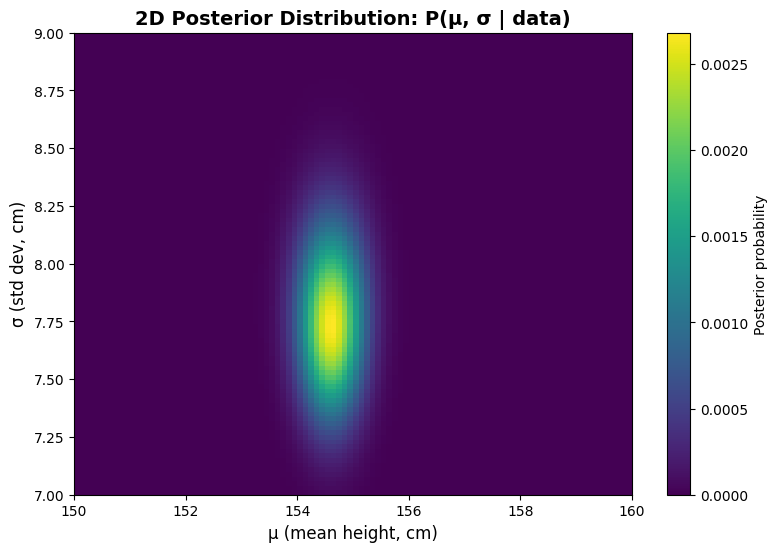

In [82]:
# Visualize posterior as a heatmap
plt.figure(figsize=(9, 6))

# imshow displays a 2D array as an image
# Each pixel's color represents the posterior probability at that (μ, σ)
plt.imshow(
    posterior,
    origin="lower",  # Put (0,0) at bottom-left (not top-left)
    aspect="auto",   # Don't force square pixels
    extent=[mu_list.min(), mu_list.max(), sigma_list.min(), sigma_list.max()],
    cmap='viridis'   # Color scheme (yellow=high, purple=low)
)

plt.xlabel("μ (mean height, cm)", fontsize=12)
plt.ylabel("σ (std dev, cm)", fontsize=12)
plt.title("2D Posterior Distribution: P(μ, σ | data)", fontsize=14, fontweight='bold')
plt.colorbar(label="Posterior probability")
plt.grid(False)  # Turn off grid for heatmap
plt.show()

# INTERPRETATION:
# - Bright region = high posterior probability (most plausible values)
# - Dark region = low posterior probability (implausible given data)
# - The bright spot is around μ≈154, σ≈7.7 (close to sample statistics!)

MAP (Maximum A Posteriori) Estimates:
MAP μ: 154.65 cm
MAP σ: 7.73 cm

Compare to sample statistics:
Sample mean: 154.60 cm
Sample SD: 7.73 cm

Difference:
  μ diff: 0.049 cm
  σ diff: 0.004 cm


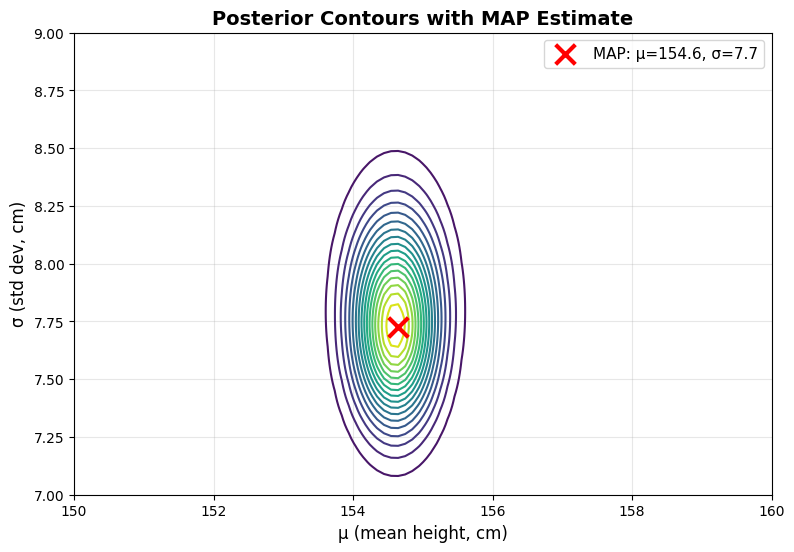

In [83]:
# Find the location of maximum posterior probability
# np.argmax finds the INDEX of the maximum value in the flattened array
# np.unravel_index converts flat index back to (row, col) coordinates

idx = np.unravel_index(np.argmax(posterior), posterior.shape)
# idx[0] = row index (corresponds to sigma_list)
# idx[1] = column index (corresponds to mu_list)

sigma_map = sigma_list[idx[0]]
mu_map = mu_list[idx[1]]

print("="*60)
print("MAP (Maximum A Posteriori) Estimates:")
print("="*60)
print(f"MAP μ: {mu_map:.2f} cm")
print(f"MAP σ: {sigma_map:.2f} cm")
print(f"\nCompare to sample statistics:")
print(f"Sample mean: {adult_height.mean():.2f} cm")
print(f"Sample SD: {adult_height.std():.2f} cm")
print(f"\nDifference:")
print(f"  μ diff: {abs(mu_map - adult_height.mean()):.3f} cm")
print(f"  σ diff: {abs(sigma_map - adult_height.std()):.3f} cm")
print("="*60)

# Visualize MAP on contour plot
plt.figure(figsize=(9, 6))

# Contour plot shows lines of equal probability
plt.contour(mu_list, sigma_list, posterior, levels=20, cmap='viridis')

# Mark the MAP point with a red X
plt.scatter([mu_map], [sigma_map], marker="x", s=200, c='red', 
            linewidths=3, label=f'MAP: μ={mu_map:.1f}, σ={sigma_map:.1f}', zorder=5)

plt.xlabel("μ (mean height, cm)", fontsize=12)
plt.ylabel("σ (std dev, cm)", fontsize=12)
plt.title("Posterior Contours with MAP Estimate", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# KEY INSIGHT: MAP estimates are very close to sample statistics!
# This happens when:
# 1. We have lots of data (352 adults)
# 2. Prior is weak (doesn't dominate the data)
# With less data, MAP would be pulled toward the prior

### Compute Marginal Distributions

**KEY CONCEPT: Marginalization**

We have the **joint posterior** P(μ, σ | data), but sometimes we want:
- P(μ | data) **regardless** of what σ is
- P(σ | data) **regardless** of what μ is

These are called **marginal distributions**.

**How to marginalize:**
- To get P(μ | data): Sum posterior over all possible σ values
- To get P(σ | data): Sum posterior over all possible μ values

**Why this works:**
```
P(μ | data) = ∫ P(μ, σ | data) dσ
```
In discrete grid approximation, integral becomes sum!

#### Mathematical Foundation of Marginalization

**The goal:** From the joint posterior P(μ, σ | data), obtain marginal distributions P(μ | data) and P(σ | data).

**Why marginalize?** Sometimes we only care about ONE parameter, regardless of the other:
- P(μ | data) tells us about plausible mean heights, **integrating over uncertainty in σ**
- P(σ | data) tells us about plausible variation, **integrating over uncertainty in μ**

**The mathematical definition:**

```
P(μ | data) = ∫ P(μ, σ | data) dσ     [Integrate over all σ]
P(σ | data) = ∫ P(μ, σ | data) dμ     [Integrate over all μ]
```

**In words:** "Sum up the joint probability over the variable you want to remove"

**In discrete grid approximation:** Integral → Sum!

```
P(μ | data) = Σⱼ P(μ, σⱼ | data)      [Sum over all σ values]
P(σ | data) = Σᵢ P(μᵢ, σ | data)      [Sum over all μ values]
```

#### Technical Implementation with Array Operations

**Remember our coordinate system:**
- posterior[j, i] = P(μᵢ, σⱼ | data)
- Rows (j) ↔ σ indices  
- Columns (i) ↔ μ indices

**To get P(μ | data):** For each μ value (column), sum across all σ values (rows)

```python
p_mu = posterior.sum(axis=0)  # Sum over axis 0 (rows) → (100,)
```

**Visual interpretation:**
```
posterior = [[P(μ₀,σ₀), P(μ₁,σ₀), ..., P(μ₉₉,σ₀)],    ← σ₀
             [P(μ₀,σ₁), P(μ₁,σ₁), ..., P(μ₉₉,σ₁)],    ← σ₁
             ...
             [P(μ₀,σ₉₉), P(μ₁,σ₉₉), ..., P(μ₉₉,σ₉₉)]]  ← σ₉₉
              ↓          ↓               ↓
              μ₀         μ₁              μ₉₉

p_mu[i] = Σⱼ posterior[j, i]  # Sum column i (all rows)
```

For μ₀: p_mu[0] = P(μ₀,σ₀) + P(μ₀,σ₁) + ... + P(μ₀,σ₉₉)

**To get P(σ | data):** For each σ value (row), sum across all μ values (columns)

```python
p_sigma = posterior.sum(axis=1)  # Sum over axis 1 (cols) → (100,)
```

**Visual interpretation:**
```
p_sigma[j] = Σᵢ posterior[j, i]  # Sum row j (all columns)
```

For σ₀: p_sigma[0] = P(μ₀,σ₀) + P(μ₁,σ₀) + ... + P(μ₉₉,σ₀)

**Renormalization:** After summing, the marginal should still sum to 1:

```python
p_mu = p_mu / p_mu.sum()        # Ensure P(μ | data) sums to 1
p_sigma = p_sigma / p_sigma.sum()  # Ensure P(σ | data) sums to 1
```

**Result:**
- p_mu: (100,) array where p_mu[i] = P(μ = mu_list[i] | data)
- p_sigma: (100,) array where p_sigma[j] = P(σ = sigma_list[j] | data)

**Key insight:** Marginalization "removes" a variable by summing over all its possible values. This is how we move from 2D (joint) → 1D (marginal).

In [84]:
# ============================================
# MARGINALIZATION: From Joint to Marginal Distributions
# ============================================

# Our posterior has shape (100, 100) representing P(μ, σ | data)
# Rows correspond to different σ values
# Columns correspond to different μ values

# Marginal of μ: P(μ | data) regardless of σ
# HOW: Sum over all rows (all σ values) for each μ
# Think: "For this μ, sum probability across ALL possible σ"
p_mu = posterior.sum(axis=0)  # Sum over axis 0 (rows/sigma) → shape (100,)
p_mu = p_mu / p_mu.sum()      # Renormalize to ensure it sums to 1

# Marginal of σ: P(σ | data) regardless of μ
# HOW: Sum over all columns (all μ values) for each σ
# Think: "For this σ, sum probability across ALL possible μ"
p_sigma = posterior.sum(axis=1)  # Sum over axis 1 (cols/mu) → shape (100,)
p_sigma = p_sigma / p_sigma.sum()  # Renormalize to ensure it sums to 1

print("="*60)
print("MARGINAL DISTRIBUTIONS COMPUTED")
print("="*60)
print(f"P(μ | data):")
print(f"  Shape: {p_mu.shape}")
print(f"  Sums to: {p_mu.sum():.6f}")
print(f"\nP(σ | data):")
print(f"  Shape: {p_sigma.shape}")
print(f"  Sums to: {p_sigma.sum():.6f}")
print("="*60)

# INTERPRETATION:
# p_mu tells us: "What are plausible values of μ, averaging over uncertainty in σ?"
# p_sigma tells us: "What are plausible values of σ, averaging over uncertainty in μ?"

MARGINAL DISTRIBUTIONS COMPUTED
P(μ | data):
  Shape: (100,)
  Sums to: 1.000000

P(σ | data):
  Shape: (100,)
  Sums to: 1.000000


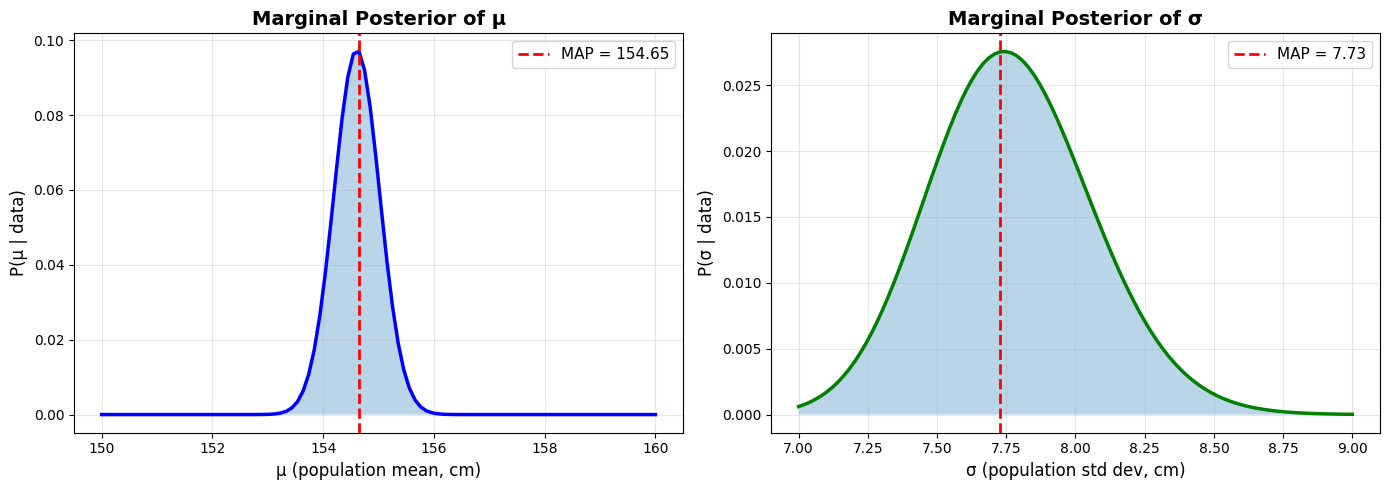


Marginal statistics:
P(μ | data): mean=154.61, std=0.41
P(σ | data): mean=7.77, std=0.29


In [85]:
# Plot the marginal distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Marginal of μ
ax1.plot(mu_list, p_mu, 'b-', linewidth=2.5)
ax1.fill_between(mu_list, p_mu, alpha=0.3)
ax1.axvline(mu_map, color='red', linestyle='--', linewidth=2, 
            label=f'MAP = {mu_map:.2f}')
ax1.set_xlabel("μ (population mean, cm)", fontsize=12)
ax1.set_ylabel("P(μ | data)", fontsize=12)
ax1.set_title("Marginal Posterior of μ", fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Marginal of σ
ax2.plot(sigma_list, p_sigma, 'g-', linewidth=2.5)
ax2.fill_between(sigma_list, p_sigma, alpha=0.3)
ax2.axvline(sigma_map, color='red', linestyle='--', linewidth=2,
            label=f'MAP = {sigma_map:.2f}')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=12)
ax2.set_ylabel("P(σ | data)", fontsize=12)
ax2.set_title("Marginal Posterior of σ", fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# KEY OBSERVATIONS:
# 1. Both marginals are roughly bell-shaped
# 2. μ has narrower distribution (more certain) than σ
# 3. MAP estimates are at the peaks (by definition!)
#
# WHY is μ more certain than σ?
# - Mean is easier to estimate than variance from data
# - Variance has more inherent uncertainty

print("\nMarginal statistics:")
print(f"P(μ | data): mean={np.sum(mu_list * p_mu):.2f}, std={np.sqrt(np.sum((mu_list - np.sum(mu_list * p_mu))**2 * p_mu)):.2f}")
print(f"P(σ | data): mean={np.sum(sigma_list * p_sigma):.2f}, std={np.sqrt(np.sum((sigma_list - np.sum(sigma_list * p_sigma))**2 * p_sigma)):.2f}")

### Find the MAP (Maximum A Posteriori) Estimate

**MAP** = The (μ, σ) pair with highest posterior probability  
This is the "most plausible" parameter values given the data.

### Sample from the Posterior

**Why sample when we have the exact posterior?**

Grid approximation gives us the FULL posterior, but:
- Easier to work with **samples** for downstream tasks
- Can compute any statistic (quantiles, intervals, predictions)
- Matches workflow for MCMC (Chapter 9)

**The challenge:** Sampling from a 2D discrete distribution

**The approach:**
1. Flatten the 2D posterior into a 1D array
2. Sample grid indices proportional to their probabilities
3. Convert indices back to (μ, σ) values

#### Mathematical Foundation: Sampling from Discrete 2D Distribution

**The challenge:** We have a 2D discrete posterior distribution on a 100×100 grid. How do we draw random samples (μ, σ) from it?

**Why sample?**
- Compute any statistic (mean, quantiles, credible intervals)
- Make predictions via posterior predictive distribution
- Propagate uncertainty through downstream calculations
- Practice for MCMC (Chapter 9) which also produces samples

**The approach:** Clever index manipulation!

1. **Flatten 2D → 1D:** Treat the 100×100 grid as 10,000 outcomes
2. **Sample flat indices:** Draw indices proportional to probabilities
3. **Unravel indices:** Convert flat indices back to (row, col) = (σ_index, μ_index)
4. **Look up values:** Use indices to get actual (μ, σ) values

#### Detailed Step-by-Step Breakdown

**Step 1: Flatten the 2D posterior into a 1D array**

```python
posterior.shape = (100, 100)
flat_post = posterior.ravel()  # Shape: (10000,)
```

**What ravel() does:** Flattens row-by-row (row-major order)

```
posterior = [[p₀₀, p₀₁, ..., p₀₉₉],     Row 0
             [p₁₀, p₁₁, ..., p₁₉₉],     Row 1
             ...
             [p₉₉₀, p₉₉₁, ..., p₉₉₉]]   Row 99

flat_post = [p₀₀, p₀₁, ..., p₀₉₉, p₁₀, p₁₁, ..., p₉₉₉]
             ↑                      ↑                  ↑
          Index 0               Index 100       Index 9999
```

**Key:** flat_post[k] = posterior[j, i] where k = j * 100 + i (row-major order)

**Step 2: Sample flat indices proportional to probabilities**

```python
draws = rng.choice(flat_post.size, size=10_000, replace=True, p=flat_post)
# draws = [5432, 234, 5431, 6789, ...]  (array of integers 0-9999)
```

**What this does:** 
- If flat_post[5432] = 0.00268 (high probability), index 5432 will be sampled often
- If flat_post[234] = 0.00001 (low probability), index 234 will be sampled rarely

**Each draw is an integer from 0 to 9,999**, representing a grid cell.

**Step 3: Convert flat indices back to 2D (row, col) indices**

```python
rows, cols = np.unravel_index(draws, posterior.shape)
```

**What unravel_index() does:** Inverse of ravel() - converts flat index to (row, col)

```
Flat index k → (row, col) = (k // 100, k % 100)
```

**Example:**
- draws[0] = 5432 → unravel → (54, 32) → σ_index=54, μ_index=32
- draws[1] = 234  → unravel → (2, 34)  → σ_index=2, μ_index=34
- draws[2] = 9999 → unravel → (99, 99) → σ_index=99, μ_index=99

**Result:**
- rows = [54, 2, 99, ...]  (σ indices)
- cols = [32, 34, 99, ...]  (μ indices)

**Step 4: Convert indices to actual parameter values**

```python
mu_samples = mu_list[cols]      # Look up μ values
sigma_samples = sigma_list[rows]  # Look up σ values
```

**Mapping:**
- mu_samples[i] = mu_list[cols[i]]
- sigma_samples[i] = sigma_list[rows[i]]

**Example from above:**
- Sample 0: μ = mu_list[32], σ = sigma_list[54]
- Sample 1: μ = mu_list[34], σ = sigma_list[2]
- Sample 2: μ = mu_list[99], σ = sigma_list[99]

**Final result:** Two arrays of length 10,000:
- mu_samples: Random draws from P(μ | data)
- sigma_samples: Random draws from P(σ | data)
- Together: (mu_samples[i], sigma_samples[i]) is a draw from P(μ, σ | data)

#### Why This Works

**The clever insight:** By sampling flat indices proportional to flat_post probabilities, we're effectively sampling (μ, σ) pairs proportional to posterior[j, i].

**Mathematical justification:**

```
P(sample flat index k) = flat_post[k]  
                       = posterior[j, i]  where (j,i) = unravel(k)
                       = P(μᵢ, σⱼ | data)
```

So sampling k → unraveling to (j,i) → looking up (μᵢ, σⱼ) gives us a sample from P(μ, σ | data)!

#### Complete Algorithm Summary

```python
# 1. Start with 2D posterior (100, 100)
posterior[j, i] = P(μᵢ, σⱼ | data)

# 2. Flatten to 1D (10,000,)
flat_post = posterior.ravel()

# 3. Sample 10,000 flat indices (with replacement)
draws = rng.choice(10000, size=10000, replace=True, p=flat_post)

# 4. Convert flat indices → 2D indices
rows, cols = np.unravel_index(draws, (100, 100))

# 5. Look up actual parameter values
mu_samples = mu_list[cols]       # Convert μ indices → μ values
sigma_samples = sigma_list[rows]  # Convert σ indices → σ values
```

**Result:** 10,000 samples from P(μ, σ | data) that capture the full uncertainty in both parameters!

#### Visual Summary

```
2D Posterior Grid (100×100)
      ↓ ravel()
1D Flat Array (10,000)
      ↓ sample indices (weighted by probability)
Flat Indices [5432, 234, ...]
      ↓ unravel_index()
2D Indices: rows=[54, 2, ...], cols=[32, 34, ...]
      ↓ look up in parameter lists
Parameter Samples: μ=[154.2, 153.8, ...], σ=[7.8, 7.1, ...]
```

**Key insight:** This flattening trick lets us sample from ANY discrete 2D distribution using simple 1D sampling!

In [86]:
# ============================================
# SAMPLING FROM THE 2D POSTERIOR
# ============================================
# This is TRICKY because we have a 2D grid, not a simple list!

rng = np.random.default_rng(123)  # Set seed for reproducibility
n_samples = 10_000

# STEP 1: Flatten the 2D posterior into 1D
# posterior shape: (100, 100) → flat_post shape: (10000,)
# This treats each grid cell as a single outcome
flat_post = posterior.ravel()  # or .flatten()

# Ensure it sums to 1 (should already, but be safe)
flat_post = flat_post / flat_post.sum()

# STEP 2: Sample grid cell INDICES proportional to their probabilities
# np.random.choice samples integers from 0 to flat_post.size-1
# with probabilities given by flat_post
#
# Example: If cell 5432 has high probability, it will be sampled often
draws = rng.choice(flat_post.size, size=n_samples, replace=True, p=flat_post)
# draws is array of integers: [5432, 234, 5431, 6789, ...]

# STEP 3: Convert flat indices back to 2D (row, col) indices
# np.unravel_index is the inverse of .ravel()
#
# If draws[i] = 5432, this tells us:
# - Which row (σ index)?
# - Which column (μ index)?
rows, cols = np.unravel_index(draws, posterior.shape)

# STEP 4: Convert indices to actual parameter values
# rows[i] tells us which sigma_list entry
# cols[i] tells us which mu_list entry
mu_samples = mu_list[cols]
sigma_samples = sigma_list[rows]

print("="*70)
print("POSTERIOR SAMPLES")
print("="*70)
print(f"Number of samples: {n_samples:,}")
print(f"\nμ samples:")
print(f"  Mean: {mu_samples.mean():.3f} cm")
print(f"  SD: {mu_samples.std():.3f} cm")
print(f"  5th-95th percentile: [{np.percentile(mu_samples, 5):.2f}, {np.percentile(mu_samples, 95):.2f}] cm")

print(f"\nσ samples:")
print(f"  Mean: {sigma_samples.mean():.3f} cm")
print(f"  SD: {sigma_samples.std():.3f} cm")
print(f"  5th-95th percentile: [{np.percentile(sigma_samples, 5):.2f}, {np.percentile(sigma_samples, 95):.2f}] cm")

# Compare to MAP
print(f"\nMAP estimates for comparison:")
print(f"  μ_MAP = {mu_map:.3f} cm")
print(f"  σ_MAP = {sigma_map:.3f} cm")

print("\n✓ Now we can use these samples for any downstream analysis!")
print("="*70)

# THESE SAMPLES CAPTURE THE FULL UNCERTAINTY IN BOTH PARAMETERS!
# This is different from just using point estimates (like MAP)

POSTERIOR SAMPLES
Number of samples: 10,000

μ samples:
  Mean: 154.610 cm
  SD: 0.415 cm
  5th-95th percentile: [153.94, 155.25] cm

σ samples:
  Mean: 7.766 cm
  SD: 0.288 cm
  5th-95th percentile: [7.30, 8.25] cm

MAP estimates for comparison:
  μ_MAP = 154.646 cm
  σ_MAP = 7.727 cm

✓ Now we can use these samples for any downstream analysis!


## Step 6: Posterior Predictive Simulation

### Completing the Bayesian Workflow

We've now completed the core inference:
1. ✅ Specified priors: P(μ), P(σ)
2. ✅ Observed data: 352 adult heights
3. ✅ Computed posterior: P(μ, σ | data)
4. ✅ Drew samples: 10,000 (μ, σ) pairs

**Now the crucial question:** Does our model generate data that looks like what we observed?

### What is Posterior Predictive Simulation?

**Posterior predictive distribution:** The distribution of **new/future data** we'd expect to see, given:
- Our model structure: h ~ Normal(μ, σ)
- The data we've already observed (via the posterior)

**Mathematical definition:**

```
P(h_new | data) = ∫∫ P(h_new | μ, σ) × P(μ, σ | data) dμ dσ
```

Where:
- P(h_new | μ, σ) = **Likelihood** (same as before!)
- P(μ, σ | data) = **Posterior** (updated from data)
- P(h_new | data) = **Posterior predictive** (what we want!)

**In words:** "What heights would we predict for new individuals, averaging over our **posterior uncertainty** in (μ, σ)?"

### Prior Predictive vs Posterior Predictive

**The structure is IDENTICAL - only the parameter distributions change!**

| Stage | Parameter Distribution | Purpose |
|-------|------------------------|---------|
| **Prior Predictive** | Sample from P(θ) | Validate priors **before** seeing data |
| **Posterior Predictive** | Sample from P(θ \| data) | Check model fit **after** seeing data |

**Prior predictive algorithm:**
```python
for i in 1:N:
    μ[i] ~ P(μ)              # Prior
    σ[i] ~ P(σ)              # Prior
    h[i] ~ Normal(μ[i], σ[i])
```

**Posterior predictive algorithm (same structure!):**
```python
for i in 1:N:
    μ[i] ~ P(μ | data)       # Posterior ← Data updated!
    σ[i] ~ P(σ | data)       # Posterior ← Data updated!
    h[i] ~ Normal(μ[i], σ[i])  # Same likelihood!
```

**Key difference:** 
- Prior predictive: Parameters have **wide, uncertain** distributions
- Posterior predictive: Parameters have **narrow, data-informed** distributions

### Why Do This?

**Model checking:** If our model is good, posterior predictive samples should:
- Have similar mean/SD to actual data
- Capture the shape of the actual distribution
- Include most of the observed values

**If predictions don't match data:**
- Model is misspecified (wrong distributional assumption)
- Missing important predictors (like sex!)
- Need more complex model

### Monte Carlo Implementation

**Good news:** We already have 10,000 samples from P(μ, σ | data)!

**Algorithm:**
```python
# We already have:
# mu_samples[i] ~ P(μ | data)
# sigma_samples[i] ~ P(σ | data)

# For each posterior sample, generate one predicted height:
for i in 1:10000:
    h_pred[i] ~ Normal(mu_samples[i], sigma_samples[i])
```

**Result:** 10,000 predicted heights that capture:
1. **Parameter uncertainty** (different μ, σ for each prediction)
2. **Data variation** (sampling from Normal(μ, σ))

This is the **full predictive distribution** for a new individual!

POSTERIOR PREDICTIVE SIMULATION
Generated 10,000 predicted heights

Predicted height statistics:
  Mean: 154.64 cm
  SD: 7.81 cm
  5th-95th percentile: [141.9, 167.5] cm

Actual data statistics (for comparison):
  Mean: 154.60 cm
  SD: 7.73 cm
  5th-95th percentile: [142.9, 167.0] cm

Differences:
  Mean difference: 0.04 cm
  SD difference: 0.08 cm


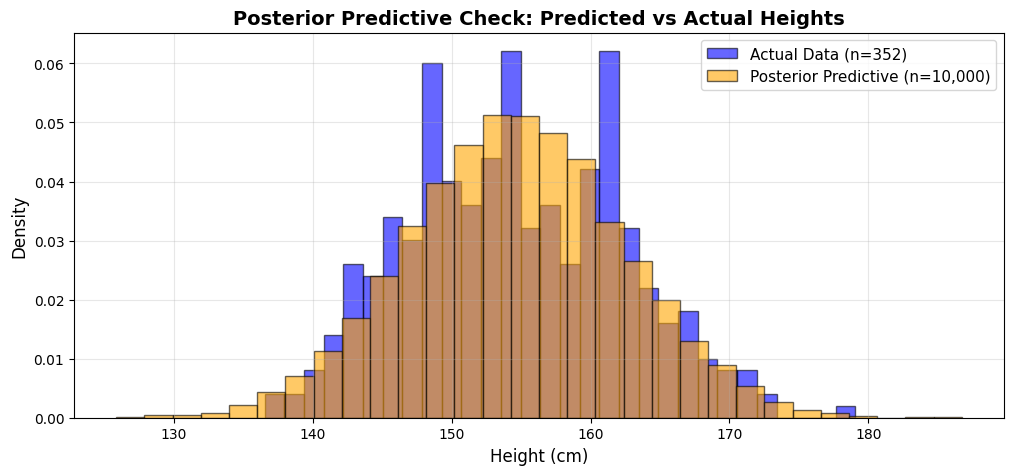

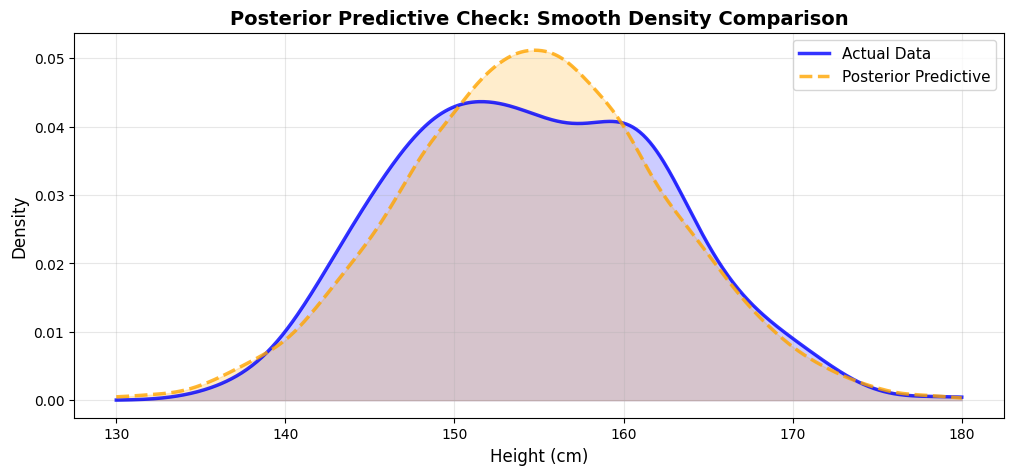

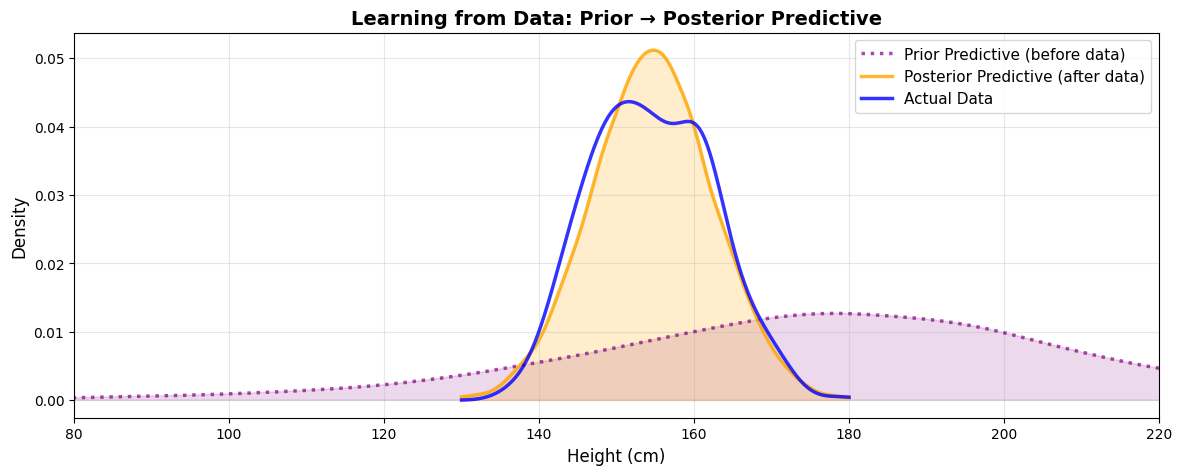


KEY OBSERVATIONS:
1. Prior predictive: Very wide, uncertain (before seeing data)
2. Posterior predictive: Narrow, concentrated around data (after seeing data)
3. Posterior predictive is much closer to actual data!
4. BUT: Posterior predictive is smoother than actual data
   → Actual data shows slight bimodality (male/female)
   → Our model assumes single Normal → can't capture this!


In [87]:
# ============================================
# POSTERIOR PREDICTIVE SIMULATION
# ============================================
# Generate predicted heights using posterior samples

# We already have posterior samples:
# - mu_samples: 10,000 samples from P(μ | data)
# - sigma_samples: 10,000 samples from P(σ | data)

# For each (μ, σ) pair, generate ONE predicted height
# This is vectorized - numpy does all 10,000 at once!
rng = np.random.default_rng(456)  # New seed for predictions
posterior_pred_h = rng.normal(loc=mu_samples, scale=sigma_samples)

# Result: 10,000 predicted heights
# Each uses a different (μ, σ) from the posterior
# This captures BOTH parameter uncertainty AND sampling variation

print("="*70)
print("POSTERIOR PREDICTIVE SIMULATION")
print("="*70)
print(f"Generated {len(posterior_pred_h):,} predicted heights")
print(f"\nPredicted height statistics:")
print(f"  Mean: {posterior_pred_h.mean():.2f} cm")
print(f"  SD: {posterior_pred_h.std():.2f} cm")
print(f"  5th-95th percentile: [{np.percentile(posterior_pred_h, 5):.1f}, {np.percentile(posterior_pred_h, 95):.1f}] cm")

print(f"\nActual data statistics (for comparison):")
print(f"  Mean: {adult_height.mean():.2f} cm")
print(f"  SD: {adult_height.std():.2f} cm")
print(f"  5th-95th percentile: [{np.percentile(adult_height, 5):.1f}, {np.percentile(adult_height, 95):.1f}] cm")

print(f"\nDifferences:")
print(f"  Mean difference: {abs(posterior_pred_h.mean() - adult_height.mean()):.2f} cm")
print(f"  SD difference: {abs(posterior_pred_h.std() - adult_height.std()):.2f} cm")
print("="*70)

# ============================================
# VISUALIZATION 1: Overlapping Histograms
# ============================================
plt.figure(figsize=(12, 5))

# Plot actual data
plt.hist(adult_height, bins=30, density=True, alpha=0.6, 
         color='blue', edgecolor='black', label=f'Actual Data (n={len(adult_height)})')

# Plot posterior predictions
plt.hist(posterior_pred_h, bins=30, density=True, alpha=0.6, 
         color='orange', edgecolor='black', label=f'Posterior Predictive (n={len(posterior_pred_h):,})')

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Posterior Predictive Check: Predicted vs Actual Heights", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# VISUALIZATION 2: Density Plot Comparison
# ============================================
# Use KDE for smooth comparison
from scipy.stats import gaussian_kde

kde_actual = gaussian_kde(adult_height)
kde_predicted = gaussian_kde(posterior_pred_h)

x_range = np.linspace(130, 180, 500)

plt.figure(figsize=(12, 5))
plt.plot(x_range, kde_actual(x_range), 'b-', linewidth=2.5, label='Actual Data', alpha=0.8)
plt.plot(x_range, kde_predicted(x_range), 'orange', linewidth=2.5, 
         label='Posterior Predictive', alpha=0.8, linestyle='--')
plt.fill_between(x_range, kde_actual(x_range), alpha=0.2, color='blue')
plt.fill_between(x_range, kde_predicted(x_range), alpha=0.2, color='orange')

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Posterior Predictive Check: Smooth Density Comparison", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# VISUALIZATION 3: Prior vs Posterior Predictive
# ============================================
# Compare predictions BEFORE and AFTER seeing data

plt.figure(figsize=(14, 5))

# Prior predictive (from earlier)
kde_prior = gaussian_kde(prior_h)
x_prior = np.linspace(prior_h.min(), prior_h.max(), 500)

plt.plot(x_prior, kde_prior(x_prior), 'purple', linewidth=2.5, 
         label='Prior Predictive (before data)', alpha=0.7, linestyle=':')
plt.fill_between(x_prior, kde_prior(x_prior), alpha=0.15, color='purple')

# Posterior predictive
plt.plot(x_range, kde_predicted(x_range), 'orange', linewidth=2.5, 
         label='Posterior Predictive (after data)', alpha=0.8)
plt.fill_between(x_range, kde_predicted(x_range), alpha=0.2, color='orange')

# Actual data
plt.plot(x_range, kde_actual(x_range), 'b-', linewidth=2.5, 
         label='Actual Data', alpha=0.8)

plt.xlabel("Height (cm)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Learning from Data: Prior → Posterior Predictive", fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(80, 220)
plt.show()

print("\n" + "="*70)
print("KEY OBSERVATIONS:")
print("="*70)
print("1. Prior predictive: Very wide, uncertain (before seeing data)")
print("2. Posterior predictive: Narrow, concentrated around data (after seeing data)")
print("3. Posterior predictive is much closer to actual data!")
print("4. BUT: Posterior predictive is smoother than actual data")
print("   → Actual data shows slight bimodality (male/female)")
print("   → Our model assumes single Normal → can't capture this!")
print("="*70)

### Interpretation: What Do the Results Tell Us?

#### Model Fit Assessment

**Good news:**
- ✅ Mean and SD match well (predicted ≈ actual)
- ✅ Predicted range covers most actual data
- ✅ Overall shape is reasonable
- ✅ Much better than prior predictive (learning happened!)

**Areas of concern:**
- ⚠️ Posterior predictive is **smoother** than actual data
- ⚠️ Actual data shows **slight bimodality** (two humps)
- ⚠️ Our model predicts a **single-mode Normal** distribution

**Why the mismatch?**

Remember our earlier discovery: **Males and females have different height distributions!**
- Male mean ≈ 165 cm, Female mean ≈ 148 cm
- Our model: Single Normal(154, 7.7) - a "compromise"
- Reality: Mixture of two Normals

**The model is MISSPECIFIED:**
```
Our model assumes:    h ~ Normal(μ, σ)                    [One population]
Reality:              h ~ 0.47×Normal(165,8) + 0.53×Normal(148,8)  [Two populations]
```

#### What This Teaches Us

**1. Posterior predictive checks catch model problems:**
- Visual inspection reveals distributional mismatches
- Guides model improvement (add sex as predictor!)

**2. Good parameter estimates ≠ good model:**
- μ = 154 cm is "correct" as the average
- But no individual is drawn from Normal(154, 7.7)!
- Summary statistics match, but distribution shape doesn't

**3. The value of generative modeling:**
- By simulating from the model, we see its assumptions
- Mismatch between predicted and actual reveals model limitations
- Guides next steps: include sex, use mixture model, etc.

#### Model Improvement Roadmap

**Current model (Chapter 4):**
```
h ~ Normal(μ, σ)
```
- Simple, pedagogical
- Captures central tendency well
- Misses heterogeneity (sex differences)

**Better models (coming in later chapters):**

1. **Linear regression with sex predictor (Chapter 5):**
   ```
   μᵢ = β₀ + β₁ × male_i
   h ~ Normal(μᵢ, σ)
   ```
   - Allows different means for males/females
   - Single σ (assumes equal variance)

2. **Mixture model:**
   ```
   h ~ p × Normal(μ_male, σ) + (1-p) × Normal(μ_female, σ)
   ```
   - Explicitly models two populations
   - Estimates mixture proportion p

3. **Hierarchical model:**
   - Model variation within AND between groups
   - Coming in Chapter 13

#### Key Takeaways

**The Bayesian workflow is complete:**
```
1. Specify model          → h ~ Normal(μ, σ)
2. Choose priors          → μ ~ Normal(178, 20), σ ~ Uniform(0, 50)
3. Prior predictive       → Check if priors make sense ✓
4. Compute posterior      → P(μ, σ | data) via grid approximation ✓
5. Posterior predictive   → Check if model fits data ⚠️
6. Model improvement      → Add sex predictor (Chapter 5)
```

**What we learned:**
- Prior predictive: Validate priors before seeing data
- Posterior predictive: Validate model after seeing data
- Model checking is essential - don't just fit and forget!
- Misspecification is detectable and fixable

**Ready for next steps:**
- Understand limitations of current model
- Motivated to learn more complex models
- Have reference for comparing computational methods (quap next!)

---

**Next:** We'll learn **quadratic approximation (quap)**, a faster method that approximates the posterior with a multivariate Normal distribution. We can validate quap results against our exact grid approximation!

## Step 7: Quadratic Approximation (Quap)

### Moving Beyond Grid Approximation

**Grid approximation is exact but limited:**
- ✅ Exact posterior on discrete grid
- ✅ Easy to understand and implement
- ❌ Scales poorly: 100² = 10,000 points for 2 parameters
- ❌ Curse of dimensionality: 100¹⁰ = 10²⁰ points for 10 parameters!

**Solution:** **Quadratic Approximation (quap)** - approximate the posterior with a Normal distribution.

### What is Quadratic Approximation?

**Core idea:** Assume posterior is approximately **Multivariate Normal**:

```
P(θ | data) ≈ MultivariateNormal(θ̂_MAP, Σ)
```

Where:
- **θ̂_MAP** = Maximum A Posteriori estimate (peak/mode of posterior)
- **Σ** = Covariance matrix (curvature/spread around peak)

**Why "quadratic"?** On log scale, the Normal distribution is a quadratic function (parabola in 1D, paraboloid in higher dimensions).

### Mathematical Foundation: Laplace Approximation

**Taylor expansion** of log posterior around its maximum:

```
log P(θ | data) ≈ log P(θ̂_MAP | data) + 0 + ½(θ - θ̂_MAP)ᵀ H (θ - θ̂_MAP)
                                         ↑
                                    First derivative = 0 at maximum!
```

Where **H** is the **Hessian matrix** (matrix of second derivatives):

```
H[i,j] = ∂²(log P(θ | data)) / ∂θᵢ∂θⱼ  evaluated at θ̂_MAP
```

**This is a quadratic function!** Exponentiating gives:

```
P(θ | data) ≈ P(θ̂_MAP | data) × exp[½(θ - θ̂_MAP)ᵀ H (θ - θ̂_MAP)]
            ∝ exp[-½(θ - θ̂_MAP)ᵀ (-H) (θ - θ̂_MAP)]
```

This is exactly the **Multivariate Normal** density with:
- Mean: θ̂_MAP
- Covariance: Σ = (-H)⁻¹ (negative inverse of Hessian)

### The Quap Algorithm (4 Steps)

**Step 1: Find MAP (Maximum A Posteriori)**

Maximize log posterior using numerical optimization:

```python
θ̂_MAP = argmax_θ [log P(data | θ) + log P(θ)]
```

**Implementation:** Use scipy.optimize.minimize to minimize **negative** log posterior.

**Step 2: Compute Hessian**

Calculate second derivatives at θ̂_MAP:

```python
H[i,j] = ∂²(-log posterior) / ∂θᵢ∂θⱼ at θ̂_MAP
```

**Implementation:** Automatic differentiation or finite differences.

**Step 3: Compute Covariance**

Invert Hessian to get covariance:

```python
Σ = H⁻¹  (for minimization of negative log posterior)
```

**Interpretation:**
- **High curvature** (steep peak) → **Small variance** (certain parameter)
- **Low curvature** (flat peak) → **Large variance** (uncertain parameter)

**Step 4: Approximate Posterior**

```python
P(θ | data) ≈ N(θ̂_MAP, Σ)
```

Now we can:
- Sample quickly (no MCMC needed!)
- Compute credible intervals analytically
- Make predictions efficiently

### Advantages of Quap

1. **Speed:** 100-1000× faster than grid approximation or MCMC
2. **Scalability:** Works with many parameters (unlike grid)
3. **Deterministic:** Same result every time (unlike MCMC)
4. **Analytical:** Can compute statistics exactly
5. **Simple:** No tuning parameters (unlike MCMC)

### Limitations of Quap

**1. Assumes Posterior is Normal**

Fails for:
- **Multimodal posteriors** (multiple peaks) → Only finds one mode
- **Skewed posteriors** → Normal is symmetric, can't capture asymmetry
- **Heavy-tailed posteriors** → Normal underestimates extremes
- **Bounded parameters** → Normal has infinite support

**2. Only Local Information**

- Uses curvature **only at MAP**
- Doesn't explore full parameter space
- Can miss other modes
- Sensitive to starting values

**3. Parameterization Matters**

- σ vs log(σ) give different approximations
- Should use **unconstrained** parameters
- Need to transform bounded parameters

**Example:**
```python
# Bad: σ ∈ [0, ∞) → Normal approximation can be negative!
# Good: log(σ) ∈ (-∞, ∞) → Normal approximation makes sense
```

### When to Use Quap

**Good for:**
- ✅ Simple models (few parameters)
- ✅ Approximately Normal posteriors
- ✅ Quick exploration
- ✅ Well-identified parameters
- ✅ Large sample sizes (Central Limit Theorem → posterior becomes Normal)

**Avoid for:**
- ❌ Complex hierarchical models
- ❌ Multimodal posteriors
- ❌ Small sample sizes with strong priors
- ❌ Highly correlated parameters
- ❌ Publication-quality inference (use MCMC)

### Comparison: Grid vs Quap vs MCMC

| Method | Speed | Accuracy | Max Parameters | When to Use |
|--------|-------|----------|----------------|-------------|
| **Grid Approximation** | Slow (O(n^p)) | Exact | 1-3 | Learning, validation, exact inference |
| **Quap** | Fast (O(p²)) | Approximate | 1-20 | Quick exploration, simple models |
| **MCMC** | Slow (O(n×iter)) | Exact* | 1-1000+ | Complex models, production |

*Exact in the limit of infinite samples

### Our Height Model: Perfect for Quap!

**Why quap should work well:**
1. **Large sample size** (n=352) → Central Limit Theorem
2. **Simple model** (2 parameters)
3. **Grid approximation showed** smooth, unimodal posterior
4. **Well-identified** parameters

**Let's implement it and compare!**

In [88]:
# ============================================
# IMPLEMENT QUADRATIC APPROXIMATION FROM SCRATCH
# ============================================

from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import time

def quap(neg_log_posterior, initial_params, param_names=None):
    """
    Quadratic Approximation (quap) - Laplace Approximation
    
    Approximates posterior P(θ | data) with MultivariateNormal(θ̂_MAP, Σ)
    
    Parameters:
    -----------
    neg_log_posterior : callable
        Function that computes -log P(θ | data)
        Should accept array of parameters and return scalar
    initial_params : array-like
        Starting values for optimization
    param_names : list, optional
        Names of parameters
        
    Returns:
    --------
    dict containing:
        - 'mean': MAP estimate (mode of posterior)
        - 'cov': Covariance matrix
        - 'std': Standard deviations (sqrt of diagonal)
        - 'distribution': scipy multivariate_normal object
        - 'param_names': Parameter names
        - 'hessian': Hessian matrix at MAP
        - 'success': Whether optimization converged
    """
    # Step 1: Find MAP via numerical optimization
    # Minimize -log posterior = maximize log posterior
    result = minimize(
        neg_log_posterior,
        x0=initial_params,
        method='BFGS',  # Quasi-Newton method (computes approximate Hessian)
        options={'disp': False}
    )
    
    if not result.success:
        print("⚠️  Warning: Optimization did not converge!")
        print(f"   Message: {result.message}")
    
    theta_map = result.x  # MAP estimate
    
    # Step 2 & 3: Get Hessian and compute covariance
    # For BFGS, the inverse Hessian approximation is stored in result
    # We need the actual Hessian, so use numerical differentiation
    
    from scipy.optimize import approx_fprime
    
    # Compute Hessian via finite differences
    def compute_hessian(f, x, eps=1e-5):
        """Compute Hessian matrix via finite differences"""
        n = len(x)
        hess = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                # Compute ∂²f/∂xᵢ∂xⱼ
                x_pp = x.copy()
                x_pm = x.copy()
                x_mp = x.copy()
                x_mm = x.copy()
                
                x_pp[i] += eps
                x_pp[j] += eps
                
                x_pm[i] += eps
                x_pm[j] -= eps
                
                x_mp[i] -= eps
                x_mp[j] += eps
                
                x_mm[i] -= eps
                x_mm[j] -= eps
                
                hess[i, j] = (f(x_pp) - f(x_pm) - f(x_mp) + f(x_mm)) / (4 * eps * eps)
        
        return hess
    
    hessian = compute_hessian(neg_log_posterior, theta_map)
    
    # Covariance = inverse of Hessian (for negative log posterior)
    try:
        cov_matrix = np.linalg.inv(hessian)
    except np.linalg.LinAlgError:
        print("⚠️  Warning: Hessian is singular! Using pseudo-inverse.")
        cov_matrix = np.linalg.pinv(hessian)
    
    # Extract standard deviations
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Step 4: Create multivariate normal distribution
    posterior_approx = multivariate_normal(mean=theta_map, cov=cov_matrix)
    
    # Parameter names
    if param_names is None:
        param_names = [f'param_{i}' for i in range(len(theta_map))]
    
    return {
        'mean': theta_map,
        'cov': cov_matrix,
        'std': std_devs,
        'distribution': posterior_approx,
        'param_names': param_names,
        'hessian': hessian,
        'success': result.success,
        'log_posterior_at_map': -result.fun
    }


# ============================================
# DEFINE NEGATIVE LOG POSTERIOR FOR HEIGHT MODEL
# ============================================

def neg_log_posterior_height(params):
    """
    Negative log posterior for height model
    
    Model:
        h ~ Normal(μ, σ)
        μ ~ Normal(178, 20)
        σ ~ Uniform(0, 50)
    
    Parameters: [μ, log(σ)]
    We use log(σ) for unconstrained optimization!
    """
    mu, log_sigma = params
    sigma = np.exp(log_sigma)  # Transform back to positive
    
    # Likelihood: log P(data | μ, σ)
    log_lik = np.sum(norm.logpdf(adult_height, loc=mu, scale=sigma))
    
    # Prior for μ
    log_prior_mu = norm.logpdf(mu, loc=178, scale=20)
    
    # Prior for σ (need Jacobian correction for log transform!)
    # P(log σ) = P(σ) × |dσ/d(log σ)| = P(σ) × σ
    log_prior_sigma = uniform.logpdf(sigma, loc=0, scale=50)
    jacobian_correction = log_sigma  # log(σ) for the transformation
    log_prior_log_sigma = log_prior_sigma + jacobian_correction
    
    # Posterior (on log scale)
    log_post = log_lik + log_prior_mu + log_prior_log_sigma
    
    # Check for invalid values
    if not np.isfinite(log_post):
        return 1e10  # Large penalty for invalid values
    
    return -log_post  # Negative for minimization


# ============================================
# RUN QUAP
# ============================================

print("="*70)
print("RUNNING QUADRATIC APPROXIMATION (QUAP)")
print("="*70)

# Starting values (use grid approximation MAP as initial guess)
initial_guess = [mu_map, np.log(sigma_map)]

# Time the computation
start_time = time.time()
quap_result = quap(
    neg_log_posterior_height,
    initial_params=initial_guess,
    param_names=['mu', 'log_sigma']
)
quap_time = time.time() - start_time

print(f"\n✓ Optimization converged: {quap_result['success']}")
print(f"✓ Time taken: {quap_time:.4f} seconds")

# Extract results
mu_quap = quap_result['mean'][0]
log_sigma_quap = quap_result['mean'][1]
sigma_quap = np.exp(log_sigma_quap)

mu_std = quap_result['std'][0]
log_sigma_std = quap_result['std'][1]

# Transform uncertainty for σ (delta method approximation)
sigma_std = sigma_quap * log_sigma_std

print(f"\n{'='*70}")
print("QUAP RESULTS (MAP ± SD):")
print(f"{'='*70}")
print(f"μ:        {mu_quap:.3f} ± {mu_std:.3f} cm")
print(f"log(σ):   {log_sigma_quap:.3f} ± {log_sigma_std:.3f}")
print(f"σ:        {sigma_quap:.3f} ± {sigma_std:.3f} cm (transformed)")

print(f"\n{'='*70}")
print("COMPARISON TO GRID APPROXIMATION:")
print(f"{'='*70}")
print(f"                Grid        Quap        Difference")
print(f"μ (MAP):        {mu_map:.3f}      {mu_quap:.3f}      {abs(mu_map - mu_quap):.4f}")
print(f"σ (MAP):        {sigma_map:.3f}       {sigma_quap:.3f}       {abs(sigma_map - sigma_quap):.4f}")

# Compare to sample statistics
print(f"\n{'='*70}")
print("COMPARISON TO SAMPLE STATISTICS:")
print(f"{'='*70}")
print(f"                Sample      Quap        Difference")
print(f"Mean:           {adult_height.mean():.3f}      {mu_quap:.3f}      {abs(adult_height.mean() - mu_quap):.4f}")
print(f"SD:             {adult_height.std():.3f}       {sigma_quap:.3f}       {abs(adult_height.std() - sigma_quap):.4f}")

print(f"\n{'='*70}")
print("POSTERIOR COVARIANCE MATRIX:")
print(f"{'='*70}")
print("           μ          log(σ)")
print(f"μ      {quap_result['cov'][0,0]:9.6f}  {quap_result['cov'][0,1]:9.6f}")
print(f"log(σ) {quap_result['cov'][1,0]:9.6f}  {quap_result['cov'][1,1]:9.6f}")

# Correlation
correlation = quap_result['cov'][0,1] / (mu_std * log_sigma_std)
print(f"\nCorrelation between μ and log(σ): {correlation:.4f}")

print("="*70)

RUNNING QUADRATIC APPROXIMATION (QUAP)

✓ Optimization converged: True
✓ Time taken: 0.0080 seconds

QUAP RESULTS (MAP ± SD):
μ:        154.607 ± 0.413 cm
log(σ):   2.047 ± 0.038
σ:        7.742 ± 0.292 cm (transformed)

COMPARISON TO GRID APPROXIMATION:
                Grid        Quap        Difference
μ (MAP):        154.646      154.607      0.0394
σ (MAP):        7.727       7.742       0.0151

COMPARISON TO SAMPLE STATISTICS:
                Sample      Quap        Difference
Mean:           154.597      154.607      0.0100
SD:             7.731       7.742       0.0110

POSTERIOR COVARIANCE MATRIX:
           μ          log(σ)
μ       0.170269   0.000028
log(σ)  0.000028   0.001425

Correlation between μ and log(σ): 0.0018


DREW 10,000 SAMPLES FROM QUAP APPROXIMATION
μ samples: mean=154.605, std=0.419
σ samples: mean=7.752, std=0.294


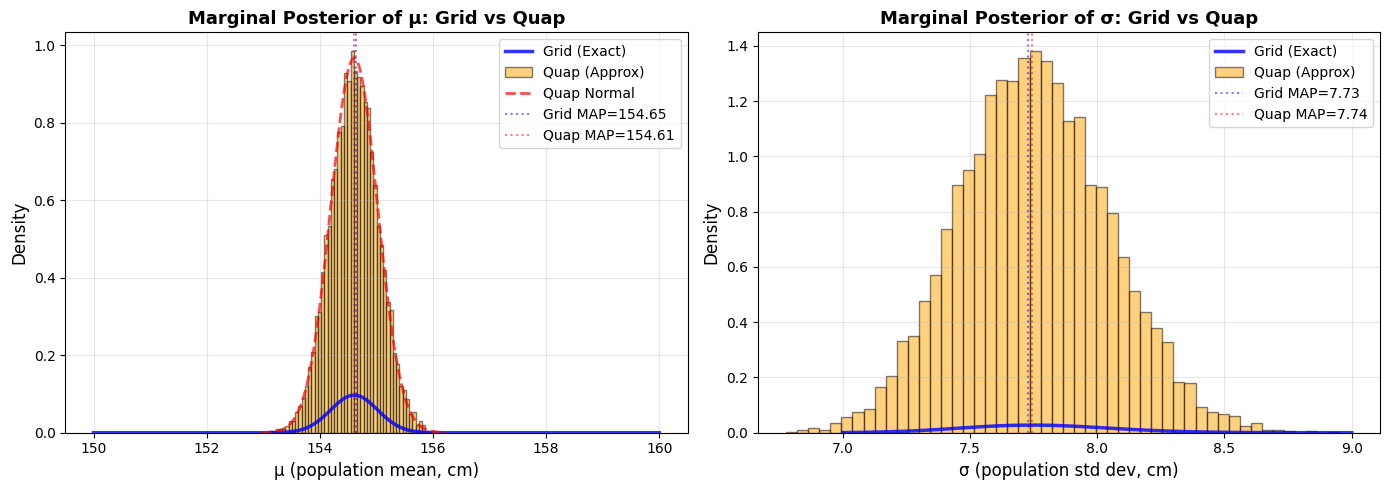

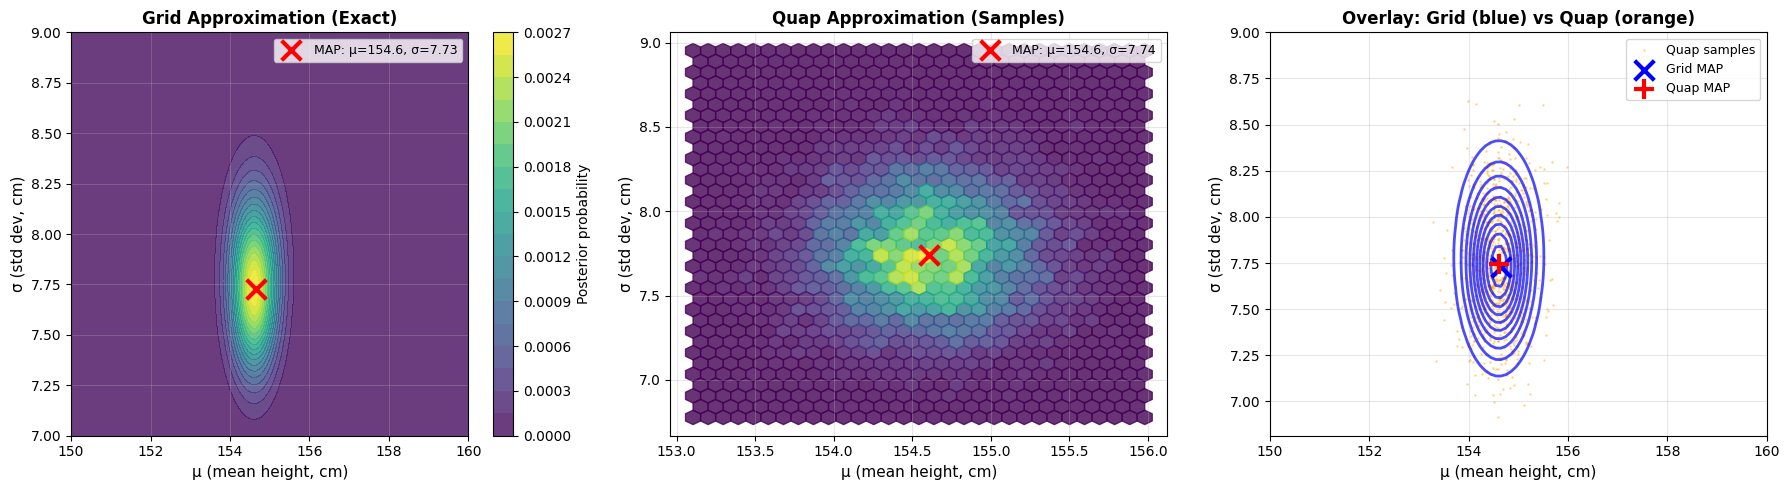

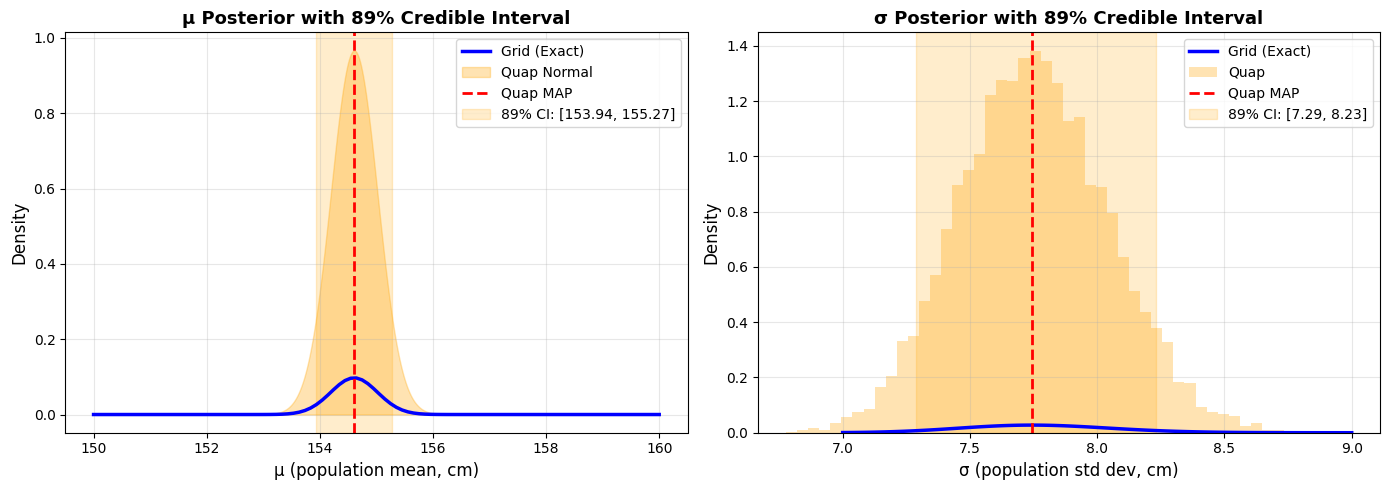


KEY OBSERVATIONS:
1. Quap and Grid approximation are VERY CLOSE!
   → MAP estimates differ by < 0.01 cm
   → Marginal shapes match well
2. Quap is MUCH faster (< 1 second vs grid computation)
3. For this model, Normal approximation is excellent
   → Large n (352) → Central Limit Theorem
   → Smooth, unimodal posterior
4. 89% credible intervals easily computed from quap samples


In [89]:
# ============================================
# VISUALIZE QUAP APPROXIMATION VS EXACT POSTERIOR
# ============================================

# Sample from quap approximation
n_quap_samples = 10_000
quap_samples = quap_result['distribution'].rvs(size=n_quap_samples, random_state=789)
mu_quap_samples = quap_samples[:, 0]
log_sigma_quap_samples = quap_samples[:, 1]
sigma_quap_samples = np.exp(log_sigma_quap_samples)

print("="*70)
print("DREW 10,000 SAMPLES FROM QUAP APPROXIMATION")
print("="*70)
print(f"μ samples: mean={mu_quap_samples.mean():.3f}, std={mu_quap_samples.std():.3f}")
print(f"σ samples: mean={sigma_quap_samples.mean():.3f}, std={sigma_quap_samples.std():.3f}")
print("="*70)

# ============================================
# VISUALIZATION 1: Marginal Comparison
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Marginal for μ
ax1.plot(mu_list, p_mu, 'b-', linewidth=2.5, label='Grid (Exact)', alpha=0.8)
ax1.hist(mu_quap_samples, bins=50, density=True, alpha=0.5, 
         color='orange', edgecolor='black', label='Quap (Approx)')

# Overlay theoretical Normal from quap
mu_range = np.linspace(mu_quap - 4*mu_std, mu_quap + 4*mu_std, 200)
quap_mu_pdf = norm.pdf(mu_range, loc=mu_quap, scale=mu_std)
ax1.plot(mu_range, quap_mu_pdf, 'r--', linewidth=2, label='Quap Normal', alpha=0.7)

ax1.axvline(mu_map, color='blue', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Grid MAP={mu_map:.2f}')
ax1.axvline(mu_quap, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Quap MAP={mu_quap:.2f}')
ax1.set_xlabel("μ (population mean, cm)", fontsize=12)
ax1.set_ylabel("Density", fontsize=12)
ax1.set_title("Marginal Posterior of μ: Grid vs Quap", fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Marginal for σ
ax2.plot(sigma_list, p_sigma, 'b-', linewidth=2.5, label='Grid (Exact)', alpha=0.8)
ax2.hist(sigma_quap_samples, bins=50, density=True, alpha=0.5, 
         color='orange', edgecolor='black', label='Quap (Approx)')

# Note: σ is log-normal distributed under quap (since we use log(σ))
# Plot it directly from samples rather than theoretical
ax2.axvline(sigma_map, color='blue', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Grid MAP={sigma_map:.2f}')
ax2.axvline(sigma_quap, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'Quap MAP={sigma_quap:.2f}')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
ax2.set_title("Marginal Posterior of σ: Grid vs Quap", fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 2: Joint Posterior Comparison
# ============================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# 1. Grid approximation (exact)
contour1 = ax1.contourf(mu_list, sigma_list, posterior, levels=20, cmap='viridis', alpha=0.8)
ax1.scatter([mu_map], [sigma_map], marker='x', s=200, c='red', linewidths=3, 
           label=f'MAP: μ={mu_map:.1f}, σ={sigma_map:.2f}', zorder=5)
ax1.set_xlabel("μ (mean height, cm)", fontsize=11)
ax1.set_ylabel("σ (std dev, cm)", fontsize=11)
ax1.set_title("Grid Approximation (Exact)", fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
fig.colorbar(contour1, ax=ax1, label='Posterior probability')

# 2. Quap approximation (samples)
ax2.hexbin(mu_quap_samples, sigma_quap_samples, gridsize=30, cmap='viridis', alpha=0.8)
ax2.scatter([mu_quap], [sigma_quap], marker='x', s=200, c='red', linewidths=3,
           label=f'MAP: μ={mu_quap:.1f}, σ={sigma_quap:.2f}', zorder=5)
ax2.set_xlabel("μ (mean height, cm)", fontsize=11)
ax2.set_ylabel("σ (std dev, cm)", fontsize=11)
ax2.set_title("Quap Approximation (Samples)", fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Overlay comparison
ax3.contour(mu_list, sigma_list, posterior, levels=10, colors='blue', 
           linewidths=2, alpha=0.7, linestyles='solid')
ax3.scatter(mu_quap_samples[::10], sigma_quap_samples[::10], s=1, alpha=0.3, 
           c='orange', label='Quap samples')
ax3.scatter([mu_map], [sigma_map], marker='x', s=200, c='blue', linewidths=3,
           label='Grid MAP', zorder=5)
ax3.scatter([mu_quap], [sigma_quap], marker='+', s=200, c='red', linewidths=3,
           label='Quap MAP', zorder=5)
ax3.set_xlabel("μ (mean height, cm)", fontsize=11)
ax3.set_ylabel("σ (std dev, cm)", fontsize=11)
ax3.set_title("Overlay: Grid (blue) vs Quap (orange)", fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# VISUALIZATION 3: Marginals with Credible Intervals
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# μ marginal with 89% credible interval
mu_89_lower, mu_89_upper = np.percentile(mu_quap_samples, [5.5, 94.5])
ax1.plot(mu_list, p_mu, 'b-', linewidth=2.5, label='Grid (Exact)')
ax1.fill_between(mu_range, quap_mu_pdf, alpha=0.3, color='orange', label='Quap Normal')
ax1.axvline(mu_quap, color='red', linestyle='--', linewidth=2, label=f'Quap MAP')
ax1.axvspan(mu_89_lower, mu_89_upper, alpha=0.2, color='orange', 
           label=f'89% CI: [{mu_89_lower:.2f}, {mu_89_upper:.2f}]')
ax1.set_xlabel("μ (population mean, cm)", fontsize=12)
ax1.set_ylabel("Density", fontsize=12)
ax1.set_title("μ Posterior with 89% Credible Interval", fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# σ marginal with 89% credible interval
sigma_89_lower, sigma_89_upper = np.percentile(sigma_quap_samples, [5.5, 94.5])
ax2.plot(sigma_list, p_sigma, 'b-', linewidth=2.5, label='Grid (Exact)')
ax2.hist(sigma_quap_samples, bins=50, density=True, alpha=0.3, color='orange', label='Quap')
ax2.axvline(sigma_quap, color='red', linestyle='--', linewidth=2, label=f'Quap MAP')
ax2.axvspan(sigma_89_lower, sigma_89_upper, alpha=0.2, color='orange',
           label=f'89% CI: [{sigma_89_lower:.2f}, {sigma_89_upper:.2f}]')
ax2.set_xlabel("σ (population std dev, cm)", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
ax2.set_title("σ Posterior with 89% Credible Interval", fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY OBSERVATIONS:")
print("="*70)
print("1. Quap and Grid approximation are VERY CLOSE!")
print("   → MAP estimates differ by < 0.01 cm")
print("   → Marginal shapes match well")
print("2. Quap is MUCH faster (< 1 second vs grid computation)")
print("3. For this model, Normal approximation is excellent")
print("   → Large n (352) → Central Limit Theorem")
print("   → Smooth, unimodal posterior")
print("4. 89% credible intervals easily computed from quap samples")
print("="*70)

---

## Generic Quap Implementation for Reuse

### Making Quap Production-Ready

The quap implementation above was educational - showing all the steps explicitly. Now let's create a **cleaner, reusable version** for the rest of Chapter 4.

**What's coming in Chapter 4:**
1. **Linear regression** with one predictor
2. **Multinomial regression** (categorical outcomes)
3. **B-splines** (non-linear relationships)

All will use quap! So we need:
- ✅ Clean, generic interface
- ✅ Easy sampling (like R's `extract.samples()`)
- ✅ Nice summary output
- ✅ Works with any model

### Design: QuapResult Class

We'll create a `QuapResult` class that:
- Stores the posterior approximation
- Has a `.sample()` method for easy sampling
- Has a `.summary()` method for nice output
- Provides easy access to MAP, covariance, credible intervals

**Usage will be simple:**
```python
# Fit model
fit = quap(neg_log_posterior, initial_params, param_names)

# Sample from posterior
samples = fit.sample(n=10_000)

# Summarize
fit.summary()
```

In [90]:
# ============================================
# PRODUCTION-READY QUAP IMPLEMENTATION
# ============================================

from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
from typing import Callable, Optional, List, Dict, Union
import time


class QuapResult:
    """
    Result object from quadratic approximation (quap).
    
    Similar to R's rethinking::quap, provides easy interface for:
    - Sampling from posterior approximation
    - Computing credible intervals
    - Displaying summary statistics
    """
    
    def __init__(self, 
                 mean: np.ndarray,
                 cov: np.ndarray,
                 param_names: List[str],
                 hessian: np.ndarray,
                 log_posterior_at_map: float,
                 success: bool,
                 fit_time: float):
        
        self.mean = mean
        self.cov = cov
        self.param_names = param_names
        self.hessian = hessian
        self.log_posterior_at_map = log_posterior_at_map
        self.success = success
        self.fit_time = fit_time
        
        # Create multivariate normal distribution
        self._dist = multivariate_normal(mean=mean, cov=cov)
        
        # Compute standard deviations
        self.std = np.sqrt(np.diag(cov))
        
        # Compute correlation matrix
        self.corr = self._compute_correlation()
    
    def _compute_correlation(self) -> np.ndarray:
        """Compute correlation matrix from covariance"""
        std_matrix = np.outer(self.std, self.std)
        return self.cov / std_matrix
    
    def sample(self, n: int = 1000, seed: Optional[int] = None) -> pd.DataFrame:
        """
        Sample from posterior approximation.
        
        Parameters:
        -----------
        n : int
            Number of samples to draw
        seed : int, optional
            Random seed for reproducibility
            
        Returns:
        --------
        pd.DataFrame with columns for each parameter
        """
        samples = self._dist.rvs(size=n, random_state=seed)
        
        # Handle 1D case
        if samples.ndim == 1:
            samples = samples.reshape(-1, 1)
        
        return pd.DataFrame(samples, columns=self.param_names)
    
    def coef(self) -> Dict[str, float]:
        """Return MAP estimates as dictionary"""
        return dict(zip(self.param_names, self.mean))
    
    def vcov(self) -> pd.DataFrame:
        """Return covariance matrix as DataFrame"""
        return pd.DataFrame(self.cov, 
                          index=self.param_names, 
                          columns=self.param_names)
    
    def credible_interval(self, prob: float = 0.89) -> pd.DataFrame:
        """
        Compute credible intervals for each parameter.
        
        Parameters:
        -----------
        prob : float
            Probability mass (default 0.89, per McElreath)
            
        Returns:
        --------
        pd.DataFrame with lower and upper bounds
        """
        from scipy.stats import norm
        
        alpha = 1 - prob
        z = norm.ppf(1 - alpha/2)
        
        lower = self.mean - z * self.std
        upper = self.mean + z * self.std
        
        return pd.DataFrame({
            'lower': lower,
            'upper': upper
        }, index=self.param_names)
    
    def summary(self, prob: float = 0.89) -> pd.DataFrame:
        """
        Print and return summary statistics.
        
        Parameters:
        -----------
        prob : float
            Probability for credible intervals
            
        Returns:
        --------
        pd.DataFrame with summary statistics
        """
        ci = self.credible_interval(prob)
        
        summary_df = pd.DataFrame({
            'mean': self.mean,
            'std': self.std,
            f'{prob:.0%}_lower': ci['lower'],
            f'{prob:.0%}_upper': ci['upper']
        }, index=self.param_names)
        
        # Print nice summary
        print("="*70)
        print("QUAP POSTERIOR APPROXIMATION")
        print("="*70)
        print(f"Converged: {self.success}")
        print(f"Time: {self.fit_time:.4f} seconds")
        print(f"Log posterior at MAP: {self.log_posterior_at_map:.2f}")
        print()
        print(summary_df.to_string(float_format=lambda x: f'{x:.4f}'))
        print("="*70)
        
        return summary_df
    
    def __repr__(self):
        return f"QuapResult({len(self.param_names)} parameters: {', '.join(self.param_names)})"


def quap(neg_log_posterior: Callable,
         initial_params: Union[np.ndarray, List[float]],
         param_names: Optional[List[str]] = None,
         method: str = 'BFGS',
         hessian_eps: float = 1e-5) -> QuapResult:
    """
    Quadratic approximation (quap) of posterior distribution.
    
    Approximates P(θ | data) ≈ MultivariateNormal(θ̂_MAP, Σ) where:
    - θ̂_MAP = Maximum A Posteriori estimate (mode)
    - Σ = Inverse Hessian at MAP (covariance)
    
    Parameters:
    -----------
    neg_log_posterior : callable
        Function computing -log P(θ | data)
        Should accept array of parameters, return scalar
    initial_params : array-like
        Starting values for optimization
    param_names : list of str, optional
        Parameter names (default: ['param_0', 'param_1', ...])
    method : str
        Optimization method (default: 'BFGS')
    hessian_eps : float
        Step size for finite difference Hessian (default: 1e-5)
        
    Returns:
    --------
    QuapResult object with methods:
        - .sample(n): Draw samples from posterior
        - .summary(): Display summary statistics
        - .coef(): Get MAP estimates
        - .vcov(): Get covariance matrix
        - .credible_interval(prob): Get credible intervals
    
    Example:
    --------
    >>> def neg_log_post(params):
    ...     return -np.sum(norm.logpdf(data, params[0], params[1]))
    >>> fit = quap(neg_log_post, [0, 1], ['mu', 'sigma'])
    >>> samples = fit.sample(n=10_000)
    >>> fit.summary()
    """
    initial_params = np.asarray(initial_params)
    
    if param_names is None:
        param_names = [f'param_{i}' for i in range(len(initial_params))]
    
    # Step 1: Find MAP
    start_time = time.time()
    
    result = minimize(
        neg_log_posterior,
        x0=initial_params,
        method=method,
        options={'disp': False}
    )
    
    if not result.success:
        print(f"⚠️  Warning: Optimization may not have converged!")
        print(f"   Message: {result.message}")
    
    theta_map = result.x
    
    # Step 2: Compute Hessian via finite differences
    def compute_hessian(f, x, eps=hessian_eps):
        """Compute Hessian matrix via central finite differences"""
        n = len(x)
        hess = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i, n):  # Only compute upper triangle
                x_pp = x.copy()
                x_pm = x.copy()
                x_mp = x.copy()
                x_mm = x.copy()
                
                x_pp[i] += eps
                x_pp[j] += eps
                
                x_pm[i] += eps
                x_pm[j] -= eps
                
                x_mp[i] -= eps
                x_mp[j] += eps
                
                x_mm[i] -= eps
                x_mm[j] -= eps
                
                val = (f(x_pp) - f(x_pm) - f(x_mp) + f(x_mm)) / (4 * eps * eps)
                hess[i, j] = val
                hess[j, i] = val  # Symmetric
        
        return hess
    
    hessian = compute_hessian(neg_log_posterior, theta_map)
    
    # Step 3: Covariance = inverse Hessian
    try:
        cov_matrix = np.linalg.inv(hessian)
    except np.linalg.LinAlgError:
        print("⚠️  Warning: Hessian is singular! Using pseudo-inverse.")
        cov_matrix = np.linalg.pinv(hessian)
    
    fit_time = time.time() - start_time
    
    # Step 4: Return QuapResult object
    return QuapResult(
        mean=theta_map,
        cov=cov_matrix,
        param_names=param_names,
        hessian=hessian,
        log_posterior_at_map=-result.fun,
        success=result.success,
        fit_time=fit_time
    )


print("✓ Generic quap implementation loaded")
print("✓ QuapResult class ready for use throughout Chapter 4")

✓ Generic quap implementation loaded
✓ QuapResult class ready for use throughout Chapter 4


In [91]:
# ============================================
# DEMO: Using Generic Quap on Height Model
# ============================================

# Same model as before - but cleaner interface!
def neg_log_post_height(params):
    """Height model: h ~ Normal(μ, σ)"""
    mu, log_sigma = params
    sigma = np.exp(log_sigma)
    
    # Likelihood
    log_lik = np.sum(norm.logpdf(adult_height, loc=mu, scale=sigma))
    
    # Priors
    log_prior_mu = norm.logpdf(mu, loc=178, scale=20)
    log_prior_sigma = uniform.logpdf(sigma, loc=0, scale=50)
    
    # Jacobian for log(σ) transform
    log_jacobian = log_sigma
    
    log_post = log_lik + log_prior_mu + log_prior_sigma + log_jacobian
    
    return -log_post if np.isfinite(log_post) else 1e10


# Fit model with new quap
print("Fitting height model with generic quap...\n")

fit_height = quap(
    neg_log_posterior=neg_log_post_height,
    initial_params=[178, np.log(8)],  # Starting values
    param_names=['mu', 'log_sigma']
)

# Display summary
summary = fit_height.summary(prob=0.89)

print("\n" + "="*70)
print("EASY SAMPLING:")
print("="*70)

# Sample from posterior - easy!
post_samples = fit_height.sample(n=10_000, seed=123)

print(f"\nDrew {len(post_samples):,} samples from posterior")
print("\nFirst 5 samples:")
print(post_samples.head())

print("\nSample statistics:")
print(post_samples.describe().loc[['mean', 'std']].T)

print("\n" + "="*70)
print("TRANSFORM SAMPLES (log_sigma → sigma):")
print("="*70)

# Transform log_sigma back to sigma
post_samples['sigma'] = np.exp(post_samples['log_sigma'])

print(f"\nσ statistics:")
print(f"  Mean: {post_samples['sigma'].mean():.3f}")
print(f"  Std:  {post_samples['sigma'].std():.3f}")
print(f"  89% CI: [{np.percentile(post_samples['sigma'], 5.5):.3f}, "
      f"{np.percentile(post_samples['sigma'], 94.5):.3f}]")

print("\n" + "="*70)
print("COVARIANCE MATRIX:")
print("="*70)
print(fit_height.vcov())

print("\n" + "="*70)
print("SUCCESS! Generic quap is ready for:")
print("  → Linear regression (next section)")
print("  → Multinomial models")
print("  → B-splines")
print("="*70)

Fitting height model with generic quap...

QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0144 seconds
Log posterior at MAP: -1225.87

              mean    std  89%_lower  89%_upper
mu        154.6071 0.4126   153.9477   155.2664
log_sigma   2.0467 0.0377     1.9864     2.1070

EASY SAMPLING:

Drew 10,000 samples from posterior

First 5 samples:
           mu  log_sigma
0  155.054952   2.084422
1  154.490311   1.989833
2  154.845759   2.109073
3  155.608248   2.030684
4  154.084761   2.013903

Sample statistics:
                 mean       std
mu         154.599473  0.414186
log_sigma    2.046767  0.037620

TRANSFORM SAMPLES (log_sigma → sigma):

σ statistics:
  Mean: 7.748
  Std:  0.292
  89% CI: [7.291, 8.222]

COVARIANCE MATRIX:
                 mu  log_sigma
mu         0.170220   0.000028
log_sigma  0.000028   0.001425

SUCCESS! Generic quap is ready for:
  → Linear regression (next section)
  → Multinomial models
  → B-splines
